In [1]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain
import csv
import re
import nltk
from tqdm import tqdm
import random
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt
import datetime
from sentence_transformers import SentenceTransformer
import pickle
import os
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertConfig, BertForSequenceClassification, TrainingArguments, AutoModelForSequenceClassification, DataCollatorWithPadding, Trainer, AutoTokenizer, TFBertModel, BertModel
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from collections import Counter
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from datasets import Dataset, DatasetDict
from evaluate import load
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\woute\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
def import_communication_data(path: str, preprocess:bool = True, remove_signoff:bool = True, newline:str = r'_/n_', reply_signs:list = None, code_words:list = None, remove_bots:bool = True, remove_names:bool = True, negation_preprocessing:bool = False, emoticon_preprocessing:bool = True, token_removal:bool = True) -> pd.DataFrame:
    print('Importing data...')
    raw_data = pd.read_csv(path, parse_dates=['reply_datetimetz']).dropna(axis = 0, subset = ['reply_from', 'reply_id', 'reply_subject', 'reply_body'])
    # Remove URLs
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$\-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', regex = True)

    if raw_data.dtypes['reply_datetimetz']=='object':
        raw_data['reply_datetimetz'] = pd.to_datetime(raw_data['reply_datetimetz'], format = 'mixed')
    raw_data.reply_datetimetz = raw_data.reply_datetimetz.dt.tz_localize(tz = 'UTC')

    regex_newline = newline.replace('/', r'\/')
    if not preprocess:
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
        return raw_data
        
    
    # raw_data['reply_body'] = raw_data['reply_body'].str.replace(newline+'.*\(\).*'+newline, regex = True) # remove most code, as we remove all sentences where brackets do not contain any information --> Tekst over code willen we erin houden
    tqdm.pandas()
    print('Removing replies...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+'\s*)+>.*?(?='+regex_newline+')', '', regex = True) # remove all replies, signified with > before the start of a sentence
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('(?:'+regex_newline+r'\s*)+\|.*?(?='+regex_newline+')', '', regex = True) # remove all replies signified with | before the start of a sentence
    print('Removing Unnecessary code-like text...')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNED MESSAGE-----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- GICM -----', '')
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- SERVER -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- CLIENT -----.*$', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'-----+\s* logs follow -----.*$', '', regex = True)
    
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----cut here-----.*-----cut here-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----8<-----.*-----8<-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----BEGIN PGP SIGNATURE-----.*-----END PGP SIGNATURE-----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'(?:^|'+regex_newline+r')((?:(?!'+regex_newline+r').)*?[Ww]rote:)', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start patch -----.*----- end patch -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- start -----.*----- end -----', '', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('-----+Build Errors-----.*error[^'+regex_newline+']*'+regex_newline, newline, regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'([+\-]*-----\+-----[+\-]*)'+regex_newline +r'.*([+\-]*-----\+-----[+\-]*)', r'\2', regex = True)
    raw_data['reply_body'].str.replace(r'([+\-]*-----+-----[+\-]*)', r'', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace('----- Forwarded [mM]essage -----.*----- End forwarded message -----', '', regex = True)
    
    
    if remove_signoff:
        print('Removing Sign-offs...')
        raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline+r'\s*-+[a-zA-Z ]*\s*'+regex_newline+r'[^\-]*-*([^\-]|(\d(-\d)+))*($|([Pp].[Ss].))', '\\4', regex = True)
    
    if reply_signs:
        print('Removing e-mail replies...')
        for reply in tqdm(reply_signs):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(reply+'.*$', '', regex = True)
            
    if code_words:
        print('Removing code words...')
        for word in tqdm(code_words):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s' + word + r'\s', '', regex = True)
    
    if remove_bots:
        print('Removing bots from entries...')
        raw_data = raw_data[~raw_data['reply_from'].str.contains(r'[\(\[\-]bot(?:[\)\]]|$)', case = False)]
        
    if remove_names:
        print('Removing Names...')
        # In order:
        # Remove quotation marks
        # Remove stuff between brackets (vaak email adressen)
        # Remove Email adresses still left in name
        # Remove dots from the name
        # Remove things added to the end of a name after - (often company of employment) (require whitespaces to make sure second names are not affected)
        # Remove entries which contain an x with a set of numbers succeeding it, as this is likely introduced by a unknown character
        # Retrieve nickname, which is usually posted between two backslashes (\...\)
        # If there is only one character (often one letter left from 2nd name/abbreviation at the start of the name), remove it
        # Remove the extra space surrounding a | token
        # Remove additional white spaces at the start/end of a token
        # Remove multiple white spaces after each other
        # Remove test and test account from the set of names
        names = set(itertools.chain(*raw_data.reply_from.str.replace('"', '').str.replace("[<(].*[>)]", '', regex = True).str.replace(r"[a-zA-Z0-9.\-_]+@\w+(.\w\w+)+", '', regex = True).str.replace('.', '').str.replace(r'\s-\s\w+($|\|)', '', regex = True).str.replace(r'(^|\|)\s*(.*),\s*(.*)($|\|)', '\\1\\3 \\2', regex = True).str.replace(r'x\d+', '', regex = True).str.replace(r'(^|\|)([^|]*)\\([^\\]+)\\([^|]*)(\||$)', '\\1\\2 \\4|\\3\\5', regex = True).str.replace(r'(^|\s)[^\|](\s|$)', ' ', regex = True).str.replace(r'\s+\|\s+', '|', regex = True).str.strip().str.replace(r'\s\s+', ' ', regex = True).str.split('|').to_list())).difference({'Test', 'Test Account', 'test', 'test account'})
        
        first_names = {name.split(' ')[0] for name in names}
        
        for name in tqdm(names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
            
        for name in tqdm(first_names):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s+'+name+r'\s+', '', regex = True, case = False)
        
    with open("SentiCR/SentiCR/Contractions.txt","r") as contractions,\
     open("SentiCR/SentiCR/EmoticonLookupTable.txt","r") as emotable:
        contractions_reader=csv.reader(contractions, delimiter='\t')
        emoticon_reader=csv.reader(emotable,delimiter='\t')
    
        #Hash words from dictionary with their values
        contractions_dict = {rows[0]:rows[1] for rows in contractions_reader}
        emodict={rows[0]:rows[1] for rows in emoticon_reader}
    
        contractions.close()
        emotable.close()
        
    print('Removing contractions...')
    contractions_regex = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: expand_contractions(x, contractions_dict, contractions_regex))
    
    if emoticon_preprocessing:
        print('Removing emoticons...')
        for emoticon in tqdm(emodict):
            raw_data['reply_body'] = raw_data['reply_body'].str.replace(emoticon, emodict[emoticon])
            
    if negation_preprocessing:
        print('Negating text...')
        raw_data['reply_body'] = raw_data['reply_body'].progress_apply(lambda x: handle_negation(x))
        
    
    print('Removing infrequent words...')

    # split words into lists
    v = raw_data['reply_body'].str.split().tolist() # [s.split() for s in df['Col2'].tolist()]
    # compute global word frequency
    c = Counter(chain.from_iterable(v))
    # filter, join, and re-assign
    raw_data['reply_body'] = [' '.join([j for j in i if c[j] > 5]) for i in v]
        
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_subject'] = raw_data['reply_subject'].str.replace(regex_newline, ' ', regex = True)
    raw_data['reply_body'] = raw_data['reply_body'].str.replace(r'\s\s+', ' ', regex = True)
    return raw_data
    
   
def import_dev_data(path:str, communication_data:pd.DataFrame = None, model = None, tokenizer = None, LR:bool = False, bert_messages:pd.DataFrame = None) -> pd.DataFrame:
    tqdm.pandas()
    print('Importing dev data')
    data = pd.read_csv(path, parse_dates=['From','To'])
    
    dates = data.From.unique()
    data.set_index(['Alias', 'From'], inplace = True)
    data['Messages Sent'] = data['Messages Sent'].fillna(0)
    
    print('Calculating Seasonality...')
    monthly_average = data.groupby(data.index.get_level_values('From').month)['Workload'].mean()
    mapped_monthly_average = data.index.get_level_values('From').map(lambda x: monthly_average.loc[x.month])
    
    data['standardized_workload'] = data['Workload']/mapped_monthly_average
    
    
    data['burnout'] = np.nan
    print('Calculating burnout per dev...')
    for developer in tqdm(data.index.levels[0].unique()):
        data = calculate_burnout(developer, data)
       
    print('Calculating lagged burnouts...')
    data['lagged_burnout'] = data.groupby(level=0)['burnout'].shift(periods = -1)
    data['burnout_t+1'] = data.apply(lambda x: calculate_lagged_burnout(x), axis = 1)
    data['burnout_t+3'] = (data.groupby(level=0)['burnout'].shift(periods = -3)) | (data.groupby(level=0)['burnout'].shift(periods = -2)) | (data['burnout_t+1']) 
    data['burnout_t+12'] = (data.groupby(level=0)['burnout'].shift(periods = -12)) | (data.groupby(level=0)['burnout'].shift(periods = -11)) | (data.groupby(level=0)['burnout'].shift(periods = -10)) |(data.groupby(level=0)['burnout'].shift(periods = -9)) | (data.groupby(level=0)['burnout'].shift(periods = -8)) |(data.groupby(level=0)['burnout'].shift(periods = -7)) | (data.groupby(level=0)['burnout'].shift(periods = -6)) |(data.groupby(level=0)['burnout'].shift(periods = -5)) | (data.groupby(level=0)['burnout'].shift(periods = -4)) | (data['burnout_t+3']) 
    
    print('Calculating Black Cloud...')
    data['black_cloud'] = (data['Radio Silence']) & (data.groupby(level = 0)['Radio Silence'].shift(periods = 1))
    
    if communication_data is None:
        # If we have not provided any communication_data, we only need the dev data
        return data
    
    print('Calculating quitting months')
    data['working_months'] = True # Indicate which months originally are worked in
    retrieved_dates = pd.Series(data.index.get_level_values(1).rename('Temp')).set_axis(data.index)
    # Quit happens when there are 3 consecutive months in which no work is performed or after the final month of work (which is not equivalent to the final month in the df)
    data['quit'] = (((data.Workload.isna()) &
                     (((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 1).isna())) |
                      ((data.groupby(level=0)['Workload'].shift(periods = 1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = 2))))) | 
                    ((data.groupby(level=0)['working_months'].shift(periods = -1).isna()) & (retrieved_dates < max(retrieved_dates))) | 
                    ((data.groupby(level=0)['Workload'].shift(periods = -1).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -2).isna()) & (data.groupby(level=0)['Workload'].shift(periods = -3).isna())))
    
    data['first_quit_month'] = ((data['quit']) & (~data.Workload.isna()))
    
    print('Calculating ragequit...')
    if bert_messages is None:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, communication_data, model, tokenizer), axis = 1)
    else:
        data['ragequit_t+1'] = data.progress_apply(lambda x: detect_ragequit(x, bert_messages, model, tokenizer), axis = 1)
    print('Calculating lagged ragequits...')
    data['ragequit_t+3'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -2)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -1)) | (data['ragequit_t+1']) 
    data['ragequit_t+12'] = (data.groupby(level=0)['ragequit_t+1'].shift(periods = -11)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -10)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -9)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -8)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -7)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -6)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -5)) |(data.groupby(level=0)['ragequit_t+1'].shift(periods = -4)) | (data.groupby(level=0)['ragequit_t+1'].shift(periods = -3)) | (data['ragequit_t+3']) 
    
    if LR:
        return data
    
    print('Reformatting communication dates')
    communication_data['reply_datetimetz'] = pd.to_datetime(communication_data['reply_datetimetz'], utc = True)
    communication_data['start_month'] = communication_data.progress_apply(lambda x: return_closest_date(x, dates), axis = 1)
    return communication_data.merge(data, how = 'left', left_on= ['reply_from', 'start_month'], right_index = True)

def import_network_data(path:str, communication_data:pd.DataFrame, communication:bool = True):
    print('Retrieving and combining network data...')
    network_data = pd.read_csv(path, parse_dates = ['start_datetime', 'end_datetime'])
    if communication:
        return communication_data.merge(network_data, how = 'left', left_on = 'start_month', right_on = 'start_datetime')
    else:
        communication_data.reset_index(inplace = True)
        return communication_data.merge(network_data, how = 'left', left_on = 'From', right_on = 'start_datetime')
    
    
def calculate_burnout(developer: str, all_dev_data: pd.DataFrame, decrease_percentage:float = 0.2, range = 3):
    all_days = pd.date_range(
        min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        max(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From')), 
        freq='30d')
    res_lst = []
    min_date = min(all_dev_data[all_dev_data.index.get_level_values('Alias') == developer].index.get_level_values('From'))+datetime.timedelta(days = range*30)
    for date in all_days:
        try:
            # Use try-except loop to include dates where there is no workload
            if date < min_date:
                # Cannot check the previous month for burnout, nor calculate it following the given definition of burnout, return NaN
                is_burnt_out = np.nan
            elif date == min_date:
                # For the fourth month, we simply have to calculate whether the deviation holds
                burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < date)]
                # Calculating the deviation, If there are too little entries, return NaN
                if len(burnout_data) < (2/3)*range:
                    is_burnt_out = np.nan
                else:
                    is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
            else:
                # We first have to retrieve the last of the previous months which were not burnt-out to find the baseline
                if False in res_lst:
                    no_burnout_month = len(res_lst) - 1 - res_lst[::-1].index(False)
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_days[no_burnout_month] < all_dev_data.index.get_level_values('From'))& (all_dev_data.index.get_level_values('From') < all_days[no_burnout_month+range])]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
                    
                else:
                    # We need to compare the workload level of this month to the first 3 in accordance with date == min_date
                    burnout_data = all_dev_data[(all_dev_data.index.get_level_values('Alias') == developer) & (all_dev_data.index.get_level_values('From') < min_date)]
                    # Calculating the deviation, If there are too little entries, return NaN
                    if len(burnout_data) < (2/3)*range:
                        is_burnt_out = np.nan
                    else:
                        is_burnt_out = all_dev_data.at[(developer, date), 'standardized_workload'] < burnout_data.standardized_workload.median() * (1-decrease_percentage)
        except:
            # Happens when there is no workload in a given month
            is_burnt_out = np.nan
                        
        res_lst.append(is_burnt_out)
            
    res_df = pd.DataFrame({'burnout':res_lst, 'extra':res_lst}, index = pd.MultiIndex.from_tuples(itertools.product([developer], all_days), names = ['Alias', 'From']))
    # Create the rows with the new months 
    all_dev_data = all_dev_data.merge(res_df[['extra']], how = 'outer', left_index = True, right_index=True).drop('extra', axis = 1)
    # Fill the burnout of the all_dev_data
    return all_dev_data.combine_first(res_df).drop('extra', axis = 1)

def calculate_lagged_burnout(data: pd.Series) -> bool:
    if np.isnan(data.burnout):
        return data.lagged_burnout
    elif np.isnan(data.lagged_burnout):
        return data.burnout
    else: 
        return data.burnout or data.lagged_burnout
        

def detect_ragequit(dev_data: pd.Series, communication_data: pd.DataFrame, model, tokenizer):
    if not dev_data.quit:
        # Can never be ragequit if dev hasn't quit
        return False
    elif dev_data.first_quit_month:
        # Dev will quit somewhere in this time period, therefore, we will need to retrieve the closest message to the end of the month to analyse
        last_date = dev_data.To
    else:
        # Not accurate if there is still communication months after the work has stopped, but feels like necessary evil to reduce calculation times and to refrain from having to go through the entire dataframe to search for the first_quit_month
        last_date = dev_data.name[1]
        
    
    dev_name = dev_data.name[0]
    try:
        dev_communication = communication_data[(communication_data.reply_from == dev_name) & (pd.to_datetime(communication_data.reply_datetimetz) < last_date)]
        last_message = dev_communication[dev_communication['reply_datetimetz'] == max(dev_communication.reply_datetimetz)].iloc[0]['reply_body']
        inputs = tokenizer(last_message, return_tensors = 'pt')
        softmax = torch.nn.functional.softmax(model(**inputs)['logits'], dim=-1)
        return softmax[0,2].item() > softmax[0,1].item() and softmax[0,2].item() > 0.15
    
    except:
        # If the developer has no messages (before the quitting date), the previous code would return an error, therefore, these developers do not rage quit, but rather silently quit
        return False
    
# def calculate_future_burnout_3(observation: pd.Series, data: pd.DataFrame) -> bool:
#     if 
        

def return_closest_date(reply: pd.Series, date_range: list):
    return date_range[pd.Series([reply.reply_datetimetz - date if (reply.reply_datetimetz - date) > datetime.timedelta(seconds = 0) else datetime.timedelta(days = 50) for date in date_range]).idxmin()]

def expand_contractions(s, contractions_dict, contractions_regex):
     def replace(match):
         return contractions_dict[match.group(0)]
     return contractions_regex.sub(replace, s.lower())

def handle_negation(comments):
    grammar= r"""
    NegP: {<VERB>?<ADV>+<VERB|ADJ>?<PRT|ADV><VERB>}
    {<VERB>?<ADV>+<VERB|ADJ>*<ADP|DET>?<ADJ>?<NOUN>?<ADV>?}
    
    """
    chunk_parser = nltk.RegexpParser(grammar)
    sentences = nltk.sent_tokenize(comments)
    modified_st=[]
    for st in sentences:
        allwords = nltk.word_tokenize(st)
        modified_words=[]
        if negated(allwords):
            part_of_speech = nltk.tag.pos_tag(allwords,tagset='universal')
            chunked = chunk_parser.parse(part_of_speech)
            #print("---------------------------")
            #print(st)
            for n in chunked:
                if isinstance(n, nltk.tree.Tree):
                    words = [pair[0] for pair in n.leaves()]
                    #print(words)

                    if n.label() == 'NegP' and negated(words):
                        for i, (word, pos) in enumerate(n.leaves()):
                            if (pos=="ADV" or pos=="ADJ" or pos=="VERB") and (word!="not"):
                                modified_words.append(prepend_not(word))
                            else:
                                modified_words.append(word)
                    else:
                         modified_words.extend(words)
                else:
                    modified_words.append(n[0])
            newst =' '.join(modified_words)
            #print(newst)
            modified_st.append(newst)
        else:
            modified_st.append(st)
    return ". ".join(modified_st)

def negated(input_words):
    """
    Determine if input contains negation words
    """
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']

    neg_words = []
    neg_words.extend(negation_words)
    for word in neg_words:
        if word in input_words:
            return True
    return False

def prepend_not(word):
    negation_words =['not', 'never', 'none', 'nobody', 'nowhere', 'neither', 'barely', 'hardly',
                     'nothing', 'rarely', 'seldom', 'despite' ]

    emoticon_words=['PositiveSentiment','NegativeSentiment']
    if word in emoticon_words:
        return word
    elif word in negation_words:
        return word
    return "NOT_"+word



In [3]:
geronimo_emails = ['----- Mensaje Original -----',
 '----- Methods required by DeploymentManager -----',
 '----- Methods required to populate Property Editors -----',
 '----- Oorspronkelijk bericht -----',
 '----- Original Message -----',
'-----Email-----',
 '-----Mensagem original-----',
 '-----Mensaje original-----',
 '-----Oorspronkelijk bericht-----',
 '-----Original Email-----',
 '-----Original Message-----',
 '-----Ursprungliche Nachricht-----',
 '-----Ursprungligt meddelande-----',
 '-----UrsprÃ¼ngliche Nachricht-----',
 '----- Forwarded Message -----',
 '----- Forwarded message -----']

code_words = ['while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone']

In [4]:
csv_path = "dev-sentiment/train_df_final.csv"
text_column = "Text"  # Change this if your column is named differently

# Output paths
output_txt = "train_corpus.txt"
tokenizer_dir = "custom-bert-tokenizer"
vocab_size = 28996  # MUST match the vocab size expected by your model

print("Reading CSV...")
df = pd.read_csv(csv_path)
df[text_column] = df[text_column].astype(str)
df[text_column].dropna().to_csv(output_txt, index=False, header=False)

print(f"Extracted {len(df)} lines of text to {output_txt}...")

# === Step 3: Train the Tokenizer ===

print("Training WordPiece tokenizer...")
tokenizer = BertWordPieceTokenizer(lowercase=True)

tokenizer.train(
    files=output_txt,
    vocab_size=vocab_size,
    min_frequency=2,
    limit_alphabet=1000,
    special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
)

# Save the trained tokenizer
os.makedirs(tokenizer_dir, exist_ok=True)
tokenizer.save_model(tokenizer_dir)

# Save in Hugging Face format
hf_tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
hf_tokenizer.save_pretrained(tokenizer_dir)

print(f"Tokenizer saved to: {tokenizer_dir}")


Reading CSV...
Extracted 4068 lines of text to train_corpus.txt...
Training WordPiece tokenizer...
Tokenizer saved to: custom-bert-tokenizer


# Geronimo Analysis

In [5]:
project_name = 'apexcore'
start_year = 2015
end_year = 2017
tokenizer = BertTokenizer.from_pretrained("custom-bert-tokenizer")

# Set the vocab size to match the checkpoint
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
config.vocab_size = 28996  # important!

# Initialize the model with the updated config
model = BertForSequenceClassification(config)

# Load the checkpoint
state_dict = torch.load("dev-sentiment/bert_model.pt", map_location="cpu")
model.load_state_dict(state_dict)

# Ik moet wel nog steeds de NaNs in ragequit+3 en +12 vullen als +1 al True is

communication_test = import_communication_data("Test/data/"+project_name+"_communication_"+str(start_year)+"-"+str(end_year)+".csv", reply_signs=geronimo_emails, remove_names=True, negation_preprocessing=False, code_words=code_words)
dev_test = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer)
all_test = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_test)

all_test

Importing data...
Removing replies...
Removing Unnecessary code-like text...
Removing Sign-offs...
Removing e-mail replies...


100%|██████████| 16/16 [00:00<00:00, 61.58it/s]


Removing code words...


100%|██████████| 88/88 [00:15<00:00,  5.51it/s]


Removing bots from entries...
Removing Names...


100%|██████████| 170/170 [00:46<00:00,  3.69it/s]


Removing contractions...


100%|██████████| 15873/15873 [00:01<00:00, 8173.57it/s] 


Removing emoticons...


100%|██████████| 96/96 [00:00<00:00, 97.62it/s]


Removing infrequent words...
Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 50/50 [00:00<00:00, 56.28it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 412/412 [00:27<00:00, 15.01it/s]


Calculating lagged ragequits...
Reformatting communication dates


100%|██████████| 15873/15873 [00:11<00:00, 1342.82it/s]


Retrieving and combining network data...


,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituPgYaDrR5t4C7LMZDyk819cWTyh7CbYudmoHZhu...,<CAJhKGzoP25snaBUUiFvzsru6zL-zHwuykEJ0r1s2pqR6...,2016-05-19 18:04:17+00:00,dev@apex.incubator.apache.org,NaN,Re: Get ApplicationId from inside Application,"specifically, you can appid = thu, may 19, 201...",-0700,...,2016-05-31 21:03:53+00:00,0.461538,0.484898,NaN,0.184941,0.463636,NaN,0.578889,0.249796,0.236364
1,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituPXsLuFOUYMMLGbZwKfn-G9w0dJaRT04g4L+64...,<CAA7LveGEhMVW=Ni-UrBJ5iBdtMRDnkUggnaapknY6TC...,2015-11-17 23:12:37+00:00,dev@apex.incubator.apache.org,NaN,Re: Creating a common metrics server for inter...,hi mostly within an operator -- things like ho...,-0800,...,2015-12-03 21:03:53+00:00,0.647059,0.355112,NaN,0.049513,0.375000,NaN,0.269630,0.346642,0.425000
2,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituMvFF5v1Oi=Va6SLiGWxvYtBnvp_C_iCaOJB5tk...,<CAKJfLDNGH9pnyegLubY8=JRgk3h-eRv=AzqsZFA8bSjJ...,2016-05-13 23:08:24+00:00,dev@apex.incubator.apache.org,NaN,Re: Windowed Operators,"the jira is here has all the fri, may 13, 2016...",-0700,...,2016-05-31 21:03:53+00:00,0.461538,0.484898,NaN,0.184941,0.463636,NaN,0.578889,0.249796,0.236364
3,2,David Yan <david@datatorrent.com> | David Yan ...,APEXCORE-350,NaN,2016-02-19 18:35:55+00:00,NaN,NaN,APEXCORE-350,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",0,...,2016-03-02 21:03:53+00:00,0.461538,0.428018,NaN,0.095499,0.380952,0.640714,0.416667,0.262458,0.619048
4,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituNkWNFBiBSroSnma1bLbjrLCx+9gjyfBxfurb=...,<CADAz6My9W5Bv5fVOF0j-GbbE_fTA-wYwAN7vXLuMn8b...,2016-03-31 20:26:55+00:00,dev@apex.incubator.apache.org,NaN,Re: Why does `-originalAppId` option for dtcli...,do not think you can re-use an old app do not ...,-0700,...,2016-04-01 21:03:53+00:00,0.500000,0.312084,NaN,0.036511,0.427273,NaN,0.155370,0.413722,0.472727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,202,rohit garg <rohit.garg41@gmail.com>,<CADFSKqg-43b4bWU_zbCi86OQH2KszWrvAZDynjYfSAHM...,NaN,2017-05-13 05:25:22+00:00,"dev@apex.apache.org, Users@apex.apache.org",NaN,[jira] [Commented] (APEXCORE-718) How to Use o...,did any one got a chance to look at it,+0530,...,2017-05-26 21:03:53+00:00,0.166667,0.381048,NaN,0.096191,0.333333,NaN,0.178571,0.199597,0.166667
15869,203,Saumya Mohan <saumya@datatorrent.com>,<CAASJqii=NpFyOsewUf=OKbhHPruHdpLmW0iVyT4mDnC2...,NaN,2017-08-21 18:18:23+00:00,dev@apex.apache.org,Sandesh Hegde <sandesh@datatorrent.com>,Adding Avro Module to encapsulate AvroFileInpu...,"hi per the above jira, we have created module ...",-0700,...,2017-08-24 21:03:53+00:00,1.000000,0.492308,NaN,0.144516,0.000000,NaN,0.000000,0.267692,0.000000
15870,204,"""rounak.digambar@blueumbrellasoft.com""<rounak....",<pony-72c4fee3af500f06d0660ec5c7f637a9de15907b...,<CA+5xAo0rHsO-TLTie5b4goimmqEtBY4c4xY4m4812OFw...,2017-09-01 13:39:35+00:00,<dev@apex.apache.org>,NaN,Re: [RESULT] [VOTE] Major version change for A...,,-0000,...,2017-09-23 21:03:53+00:00,1.000000,0.369565,NaN,0.193497,0.000000,NaN,NaN,0.239130,0.000000
15871,204,"""rounak.digambar@blueumbrellasoft.com""<rounak....",<pony-72c4fee3af500f06d0660ec5c7f637a9de15907b...,<CAA7LveF54dc9keFxATGJQDUTfvaAq_=bnf6UeXdiN-Dv...,2017-09-01 13:43:11+00:00,<dev@apex.apache.org>,NaN,Re: [RESULT] [VOTE] Major version change for A...,,-0000,...,2017-09-23 21:03:53+00:00,1.000000,0.369565,NaN,0.193497,0.000000,NaN,NaN,0.239130,0.000000


In [6]:
all_test[['burnout', 'burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12']].mean()

burnout          0.394709
burnout_t+1      0.530666
burnout_t+3      0.353306
burnout_t+12     0.383546
ragequit_t+1     0.019346
ragequit_t+3     0.065928
ragequit_t+12    0.123591
dtype: object

In [7]:
all_test.to_csv('Test/data/'+project_name+'_all_message_data.csv')

In [3]:
all_test = pd.read_csv('Test/data/apexcore_all_message_data.csv', parse_dates = ['reply_datetimetz', 'start_month', 'To', 'start_datetime', 'end_datetime']).drop('Unnamed: 0', axis = 1)
all_test

,identity_id,reply_from,reply_id,in_reply_to_id,reply_datetimetz,reply_to,reply_cc,reply_subject,reply_body,reply_tz,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituPgYaDrR5t4C7LMZDyk819cWTyh7CbYudmoHZhu...,<CAJhKGzoP25snaBUUiFvzsru6zL-zHwuykEJ0r1s2pqR6...,2016-05-19 18:04:17+00:00,dev@apex.incubator.apache.org,NaN,Re: Get ApplicationId from inside Application,"specifically, you can appid = thu, may 19, 201...",-0700,...,2016-05-31 21:03:53+00:00,0.461538,0.484898,NaN,0.184941,0.463636,NaN,0.578889,0.249796,0.236364
1,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituPXsLuFOUYMMLGbZwKfn-G9w0dJaRT04g4L+64...,<CAA7LveGEhMVW=Ni-UrBJ5iBdtMRDnkUggnaapknY6TC...,2015-11-17 23:12:37+00:00,dev@apex.incubator.apache.org,NaN,Re: Creating a common metrics server for inter...,hi mostly within an operator -- things like ho...,-0800,...,2015-12-03 21:03:53+00:00,0.647059,0.355112,NaN,0.049513,0.375000,NaN,0.269630,0.346642,0.425000
2,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituMvFF5v1Oi=Va6SLiGWxvYtBnvp_C_iCaOJB5tk...,<CAKJfLDNGH9pnyegLubY8=JRgk3h-eRv=AzqsZFA8bSjJ...,2016-05-13 23:08:24+00:00,dev@apex.incubator.apache.org,NaN,Re: Windowed Operators,"the jira is here has all the fri, may 13, 2016...",-0700,...,2016-05-31 21:03:53+00:00,0.461538,0.484898,NaN,0.184941,0.463636,NaN,0.578889,0.249796,0.236364
3,2,David Yan <david@datatorrent.com> | David Yan ...,APEXCORE-350,NaN,2016-02-19 18:35:55+00:00,NaN,NaN,APEXCORE-350,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",0,...,2016-03-02 21:03:53+00:00,0.461538,0.428018,NaN,0.095499,0.380952,0.640714,0.416667,0.262458,0.619048
4,2,David Yan <david@datatorrent.com> | David Yan ...,<CAMqituNkWNFBiBSroSnma1bLbjrLCx+9gjyfBxfurb=...,<CADAz6My9W5Bv5fVOF0j-GbbE_fTA-wYwAN7vXLuMn8b...,2016-03-31 20:26:55+00:00,dev@apex.incubator.apache.org,NaN,Re: Why does `-originalAppId` option for dtcli...,do not think you can re-use an old app do not ...,-0700,...,2016-04-01 21:03:53+00:00,0.500000,0.312084,NaN,0.036511,0.427273,NaN,0.155370,0.413722,0.472727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,202,rohit garg <rohit.garg41@gmail.com>,<CADFSKqg-43b4bWU_zbCi86OQH2KszWrvAZDynjYfSAHM...,NaN,2017-05-13 05:25:22+00:00,"dev@apex.apache.org, Users@apex.apache.org",NaN,[jira] [Commented] (APEXCORE-718) How to Use o...,did any one got a chance to look at it,+0530,...,2017-05-26 21:03:53+00:00,0.166667,0.381048,NaN,0.096191,0.333333,NaN,0.178571,0.199597,0.166667
15869,203,Saumya Mohan <saumya@datatorrent.com>,<CAASJqii=NpFyOsewUf=OKbhHPruHdpLmW0iVyT4mDnC2...,NaN,2017-08-21 18:18:23+00:00,dev@apex.apache.org,Sandesh Hegde <sandesh@datatorrent.com>,Adding Avro Module to encapsulate AvroFileInpu...,"hi per the above jira, we have created module ...",-0700,...,2017-08-24 21:03:53+00:00,1.000000,0.492308,NaN,0.144516,0.000000,NaN,0.000000,0.267692,0.000000
15870,204,"""rounak.digambar@blueumbrellasoft.com""<rounak....",<pony-72c4fee3af500f06d0660ec5c7f637a9de15907b...,<CA+5xAo0rHsO-TLTie5b4goimmqEtBY4c4xY4m4812OFw...,2017-09-01 13:39:35+00:00,<dev@apex.apache.org>,NaN,Re: [RESULT] [VOTE] Major version change for A...,,-0000,...,2017-09-23 21:03:53+00:00,1.000000,0.369565,NaN,0.193497,0.000000,NaN,NaN,0.239130,0.000000
15871,204,"""rounak.digambar@blueumbrellasoft.com""<rounak....",<pony-72c4fee3af500f06d0660ec5c7f637a9de15907b...,<CAA7LveF54dc9keFxATGJQDUTfvaAq_=bnf6UeXdiN-Dv...,2017-09-01 13:43:11+00:00,<dev@apex.apache.org>,NaN,Re: [RESULT] [VOTE] Major version change for A...,,-0000,...,2017-09-23 21:03:53+00:00,1.000000,0.369565,NaN,0.193497,0.000000,NaN,NaN,0.239130,0.000000


In [9]:
dev_data = import_dev_data('Test/data/dev_data_'+project_name+'.csv', communication_test, model, tokenizer, LR = True)
logistic_data = import_network_data('Test/data/network_data_'+project_name+'.csv', dev_data, communication=False).dropna(axis = 0, subset = ['Radio Silence', 'Organisational Silo', 'Lone Wolf'])
logistic_data.to_csv('Test/data/'+project_name+'_logistic_data.csv')
logistic_data

Importing dev data
Calculating Seasonality...
Calculating burnout per dev...


100%|██████████| 50/50 [00:00<00:00, 60.11it/s]


Calculating lagged burnouts...
Calculating Black Cloud...
Calculating quitting months
Calculating ragequit...


100%|██████████| 412/412 [00:17<00:00, 23.99it/s]

Calculating lagged ragequits...
Retrieving and combining network data...


,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Andy Perlitch <andyperlitch@gmail.com> | Andy ...,2015-10-04 21:03:53+00:00,2.000000,True,5.0,False,True,2015-11-03 21:03:53+00:00,15.0,NaN,...,2015-11-03 21:03:53+00:00,0.666667,0.427755,NaN,0.103175,0.333333,NaN,0.184127,0.225306,0.200000
1,Aniruddha Thombre <aniruddha@aniruddhas.com> |...,2015-09-04 21:03:53+00:00,2.625000,True,8.0,True,False,2015-10-04 21:03:53+00:00,7.0,NaN,...,2015-10-04 21:03:53+00:00,0.406977,0.376320,NaN,0.098591,0.389474,NaN,0.100734,0.231523,0.452632
2,Apex Dev <dev@apex.apache.org>,2016-11-27 21:03:53+00:00,NaN,True,0.0,True,False,2016-12-27 21:03:53+00:00,192.0,NaN,...,2016-12-27 21:03:53+00:00,0.300000,0.290541,NaN,0.091698,0.218182,NaN,0.222222,0.181682,0.181818
3,Apex Dev <dev@apex.apache.org>,2016-12-27 21:03:53+00:00,NaN,False,0.0,False,False,2017-01-26 21:03:53+00:00,6.0,NaN,...,2017-01-26 21:03:53+00:00,0.363636,0.274538,NaN,0.047655,0.319444,NaN,0.147321,0.157895,0.305556
6,Apex Dev <dev@apex.apache.org>,2017-03-27 21:03:53+00:00,NaN,True,0.0,True,False,2017-04-26 21:03:53+00:00,846.0,False,...,2017-04-26 21:03:53+00:00,0.315789,0.429803,NaN,0.136480,0.222222,0.300024,0.239955,0.177340,0.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-03-27 21:03:53+00:00,2.500000,True,34.0,True,True,2017-04-26 21:03:53+00:00,655.0,NaN,...,2017-04-26 21:03:53+00:00,0.315789,0.429803,NaN,0.136480,0.222222,0.300024,0.239955,0.177340,0.527778
407,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-04-26 21:03:53+00:00,NaN,False,29.0,False,False,2017-05-26 21:03:53+00:00,45.0,NaN,...,2017-05-26 21:03:53+00:00,0.166667,0.381048,NaN,0.096191,0.333333,NaN,0.178571,0.199597,0.166667
409,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-06-25 21:03:53+00:00,2.333333,True,16.0,False,True,2017-07-25 21:03:53+00:00,127.0,NaN,...,2017-07-25 21:03:53+00:00,0.166667,0.447368,NaN,0.206221,0.214286,NaN,0.000000,0.163743,0.214286
410,twigglius <armccullough@gmail.com> | twigglius...,2016-10-28 21:03:53+00:00,1.000000,False,3.0,False,False,2016-11-27 21:03:53+00:00,15.0,NaN,...,2016-11-27 21:03:53+00:00,0.750000,0.389113,NaN,0.125917,0.133333,NaN,0.280000,0.223790,0.266667


In [4]:
project_name = 'apexcore'
start_year = 2015
end_year = 2017

logistic_data = pd.read_csv('Test/data/'+project_name+'_logistic_data.csv', parse_dates = ['To', 'start_datetime', 'end_datetime']).astype({'burnout':bool}).drop('Unnamed: 0', axis = 1)
logistic_data

,Alias,From,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,To,Workload,burnout,...,end_datetime,st_congruence,reply_degree,reply_close,reply_between,git_degree,git_close,git_between,reply_density,git_density
0,Andy Perlitch <andyperlitch@gmail.com> | Andy ...,2015-10-04 21:03:53+00:00,2.000000,True,5.0,False,True,2015-11-03 21:03:53+00:00,15.0,True,...,2015-11-03 21:03:53+00:00,0.666667,0.427755,NaN,0.103175,0.333333,NaN,0.184127,0.225306,0.200000
1,Aniruddha Thombre <aniruddha@aniruddhas.com> |...,2015-09-04 21:03:53+00:00,2.625000,True,8.0,True,False,2015-10-04 21:03:53+00:00,7.0,True,...,2015-10-04 21:03:53+00:00,0.406977,0.376320,NaN,0.098591,0.389474,NaN,0.100734,0.231523,0.452632
2,Apex Dev <dev@apex.apache.org>,2016-11-27 21:03:53+00:00,NaN,True,0.0,True,False,2016-12-27 21:03:53+00:00,192.0,True,...,2016-12-27 21:03:53+00:00,0.300000,0.290541,NaN,0.091698,0.218182,NaN,0.222222,0.181682,0.181818
3,Apex Dev <dev@apex.apache.org>,2016-12-27 21:03:53+00:00,NaN,False,0.0,False,False,2017-01-26 21:03:53+00:00,6.0,True,...,2017-01-26 21:03:53+00:00,0.363636,0.274538,NaN,0.047655,0.319444,NaN,0.147321,0.157895,0.305556
4,Apex Dev <dev@apex.apache.org>,2017-03-27 21:03:53+00:00,NaN,True,0.0,True,False,2017-04-26 21:03:53+00:00,846.0,False,...,2017-04-26 21:03:53+00:00,0.315789,0.429803,NaN,0.136480,0.222222,0.300024,0.239955,0.177340,0.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-03-27 21:03:53+00:00,2.500000,True,34.0,True,True,2017-04-26 21:03:53+00:00,655.0,True,...,2017-04-26 21:03:53+00:00,0.315789,0.429803,NaN,0.136480,0.222222,0.300024,0.239955,0.177340,0.527778
251,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-04-26 21:03:53+00:00,NaN,False,29.0,False,False,2017-05-26 21:03:53+00:00,45.0,True,...,2017-05-26 21:03:53+00:00,0.166667,0.381048,NaN,0.096191,0.333333,NaN,0.178571,0.199597,0.166667
252,tweise <thomas.weise@gmail.com> | Thomas Weise...,2017-06-25 21:03:53+00:00,2.333333,True,16.0,False,True,2017-07-25 21:03:53+00:00,127.0,True,...,2017-07-25 21:03:53+00:00,0.166667,0.447368,NaN,0.206221,0.214286,NaN,0.000000,0.163743,0.214286
253,twigglius <armccullough@gmail.com> | twigglius...,2016-10-28 21:03:53+00:00,1.000000,False,3.0,False,False,2016-11-27 21:03:53+00:00,15.0,True,...,2016-11-27 21:03:53+00:00,0.750000,0.389113,NaN,0.125917,0.133333,NaN,0.280000,0.223790,0.266667


# Modeling

### Burnout - LR

In [141]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close', 'Workload'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree'], axis = 1).dropna().astype({'burnout':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout'])

In [142]:
logistic_train_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,burnout,standardized_workload,black_cloud,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,140.000000,140,140.000000,140,140,140,140.000000,140,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
unique,NaN,2,NaN,2,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,True,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,113,NaN,96,95,112,NaN,102,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.173624,NaN,22.600000,NaN,NaN,NaN,1.097316,NaN,0.466236,0.359594,0.102049,0.269457,0.222550,0.353848
std,1.059760,NaN,20.934567,NaN,NaN,NaN,2.063709,NaN,0.155857,0.061942,0.041118,0.175684,0.087468,0.149109
min,1.000000,NaN,1.000000,NaN,NaN,NaN,0.003014,NaN,0.166667,0.259740,0.036511,0.000000,0.085990,0.163636
25%,1.475000,NaN,7.000000,NaN,NaN,NaN,0.103131,NaN,0.363636,0.312084,0.084242,0.155370,0.162415,0.200000
50%,2.000000,NaN,16.000000,NaN,NaN,NaN,0.390593,NaN,0.444444,0.355112,0.098591,0.222222,0.225306,0.365278
75%,2.666667,NaN,31.500000,NaN,NaN,NaN,1.411745,NaN,0.500000,0.427755,0.129434,0.326531,0.257143,0.493182


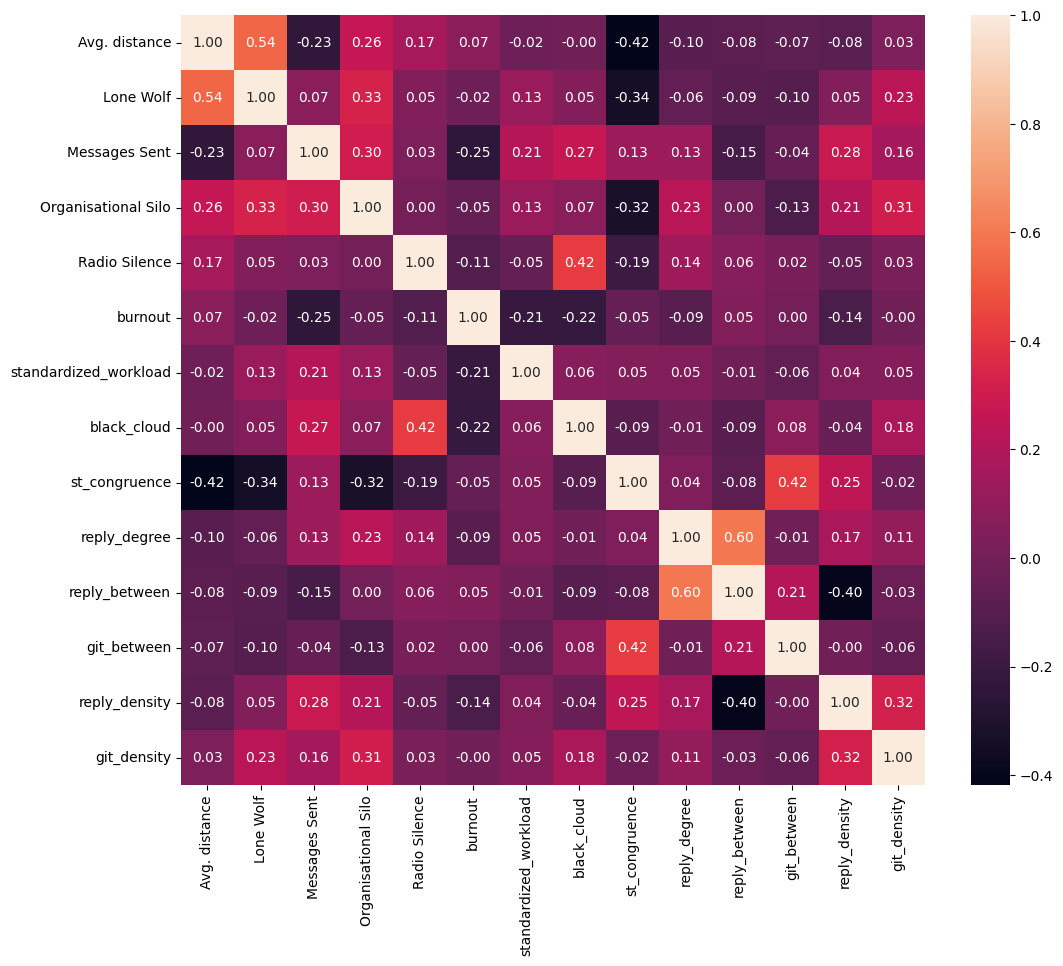

In [143]:
fig = plt.figure(figsize=(12,10))
ax= plt.subplot()
sns.heatmap(logistic_train_data.astype(float).corr(), annot=True, ax = ax, fmt = '.2f');
# fig.savefig('correlations_geronimo.png')

In [144]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout', axis = 1), logistic_train_data['burnout'])

Text(45.722222222222214, 0.5, 'True class')

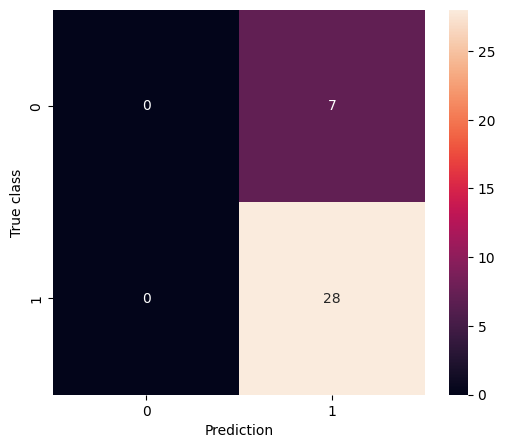

In [145]:
cm = confusion_matrix(logistic_test_data['burnout'], lr_model.predict(logistic_test_data.drop('burnout', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [146]:
stat_model = sm.Logit(logistic_train_data['burnout'].astype(float), sm.add_constant(logistic_train_data.drop('burnout', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                burnout   No. Observations:                  140
Model:                          Logit   Df Residuals:                      126
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1263
Time:                        03:21:00   Log-Likelihood:                -61.209
converged:                       True   LL-Null:                       -70.056
Covariance Type:            nonrobust   LLR p-value:                    0.1695
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.2523      1.879      1.731      0.083      -0.431       6.935
Avg. distance             0.1613      0.353      0.457      0.647      -0.530       0.852
Lone Wolf                -0.2008      0.770     -0.261      0.794      -1.709       1.308
Messages Sent            -0.0139      0.012     -1.134      0.257      -0.038       0.010
Organisational Silo       0.2702      0.622      0.434      0.664      -0.949       1.490
Radio Silence            -0.3185      0.647     -0.492      0.623      -1.587       0.950
standardized_workload    -0.1812      0.096     -1.885      0.059      -0.370       0.007
black_cloud              -0.9997      0.594     -1.682      0.093      -2.164       0.165
st_congruence             0.2591      2.099      0.123      0.902      -3.854       4.372
reply_degree             -1.6065      6.335     -0.254      0.800     -14.023      10.810
reply_between            -1.7021     10.549     -0.161      0.872     -22.378      18.974
git_between               0.3365      1.662      0.203      0.840      -2.920       3.593
reply_density            -4.2726      3.797     -1.125      0.260     -11.715       3.169
git_density               1.5871      1.796      0.883      0.377      -1.934       5.108
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

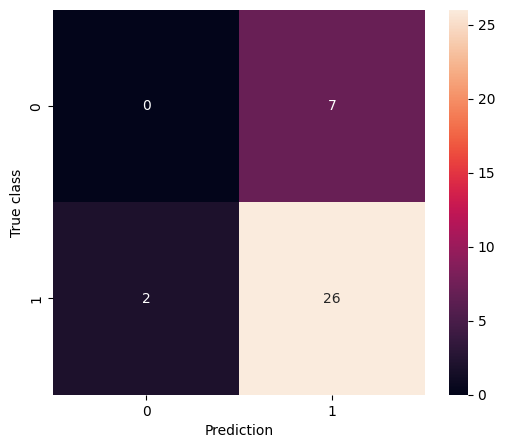

In [147]:
cm = confusion_matrix(logistic_test_data['burnout'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [5]:
message_data = all_test[['reply_body', 'burnout']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout'] = message_data['burnout'].astype(bool)
message_data

100%|██████████| 1856/1856 [00:19<00:00, 97.46it/s] 


,reply_body,burnout,lemmas
1,hi mostly within an operator -- things like ho...,True,"[hi, operator, thing, like, bufferserver, tupl..."
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
5,i should have mentioned that i had a pull requ...,False,"[mention, pull, request, merge, correct, thu, ..."
6,i of please let me knowyou the idea behind of ...,False,"[let, knowyou, idea, constructor, say, recover..."
...,...,...,...
5832,should be fine. please go ahead,False,"[fine, ahead]"
5836,@pramodssimmaneni could you please reviewmerge ?,False,[reviewmerge]
6194,there are still some minor details that i want...,True,"[minor, detail, want, care, course, week]"
6204,- rebase @vrozov,True,[rebase]


In [6]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if 3*message_train["burnout"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==1].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
        print(f'Positive cases: {message_train["burnout"].sum()}')

        if message_train["burnout"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train['burnout']==0].index], message_train])
            print(f'Positive cases: {message_train["burnout"].sum()}')

        nMax = len(message_train) - message_train["burnout"].sum()
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout"].sum()
        print(f'Positive cases: {message_train["burnout"].sum()}')
        message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 1235
length of validation set: 265
length of test set: 265
Positive cases: 358
New length of train set: 716


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1081622227.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1081622227.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby('burnout').apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [7]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                   pos_importance  pos_occur  total_appearances
hi                       0.548673       62.0              113.0
user                     0.538462       77.0              143.0
fix                      0.504762       53.0              105.0
use                      0.494048       83.0              168.0
add                      0.483696       89.0              184.0
window                   0.472868       61.0              129.0
pm                       0.468750       60.0              128.0
change                   0.455814       98.0              215.0
application              0.439716       62.0              141.0
think                    0.439490       69.0              157.0
need                     0.424028      120.0              283.0
review                   0.423729       50.0              118.0
tue                      0.410853       53.0              129.0
PositiveSentiment        0.396396       88.0              222.0
file                     0.3

In [8]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.66      0.59      0.63       160\n        True       0.47      0.54      0.50       105\n\n    accuracy                           0.57       265\n   macro avg       0.57      0.57      0.56       265\nweighted avg       0.59      0.57      0.58       265\n'

Text(45.722222222222214, 0.5, 'True class')

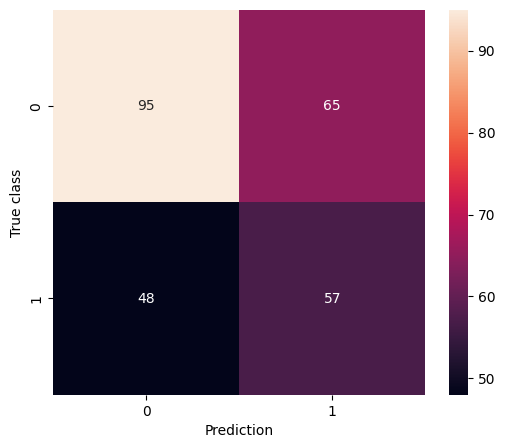

In [9]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [10]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.56      0.12      0.20       160\n        True       0.39      0.85      0.53       105\n\n    accuracy                           0.41       265\n   macro avg       0.47      0.49      0.37       265\nweighted avg       0.49      0.41      0.33       265\n'

Text(45.722222222222214, 0.5, 'True class')

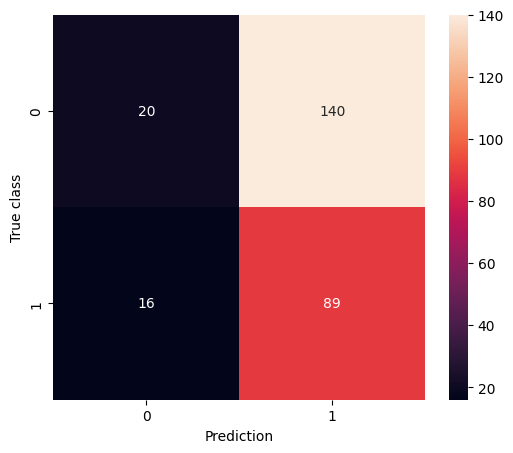

In [11]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [12]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.66      0.48      0.56       160\n        True       0.44      0.62      0.51       105\n\n    accuracy                           0.54       265\n   macro avg       0.55      0.55      0.53       265\nweighted avg       0.57      0.54      0.54       265\n'

Text(45.722222222222214, 0.5, 'True class')

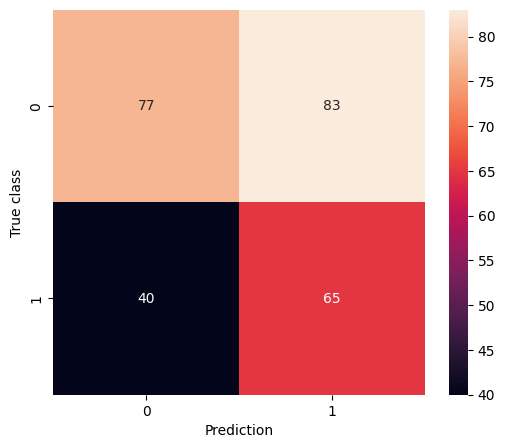

In [13]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [14]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.67      0.74      0.71       160\n        True       0.53      0.45      0.49       105\n\n    accuracy                           0.63       265\n   macro avg       0.60      0.60      0.60       265\nweighted avg       0.62      0.63      0.62       265\n'

Text(45.722222222222214, 0.5, 'True class')

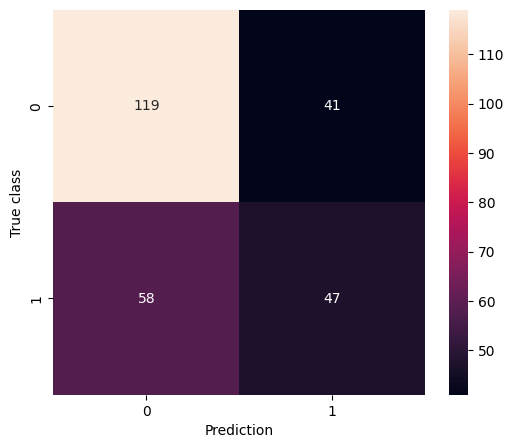

In [15]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [16]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.61      0.54      0.57       160\n        True       0.40      0.48      0.44       105\n\n    accuracy                           0.51       265\n   macro avg       0.51      0.51      0.50       265\nweighted avg       0.53      0.51      0.52       265\n'

Text(45.722222222222214, 0.5, 'True class')

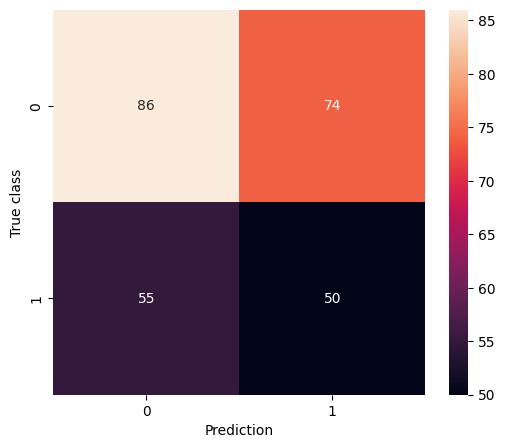

In [17]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [18]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout'])

classification_report(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.66      0.51      0.57       160\n        True       0.45      0.61      0.52       105\n\n    accuracy                           0.55       265\n   macro avg       0.56      0.56      0.55       265\nweighted avg       0.58      0.55      0.55       265\n'

Text(45.722222222222214, 0.5, 'True class')

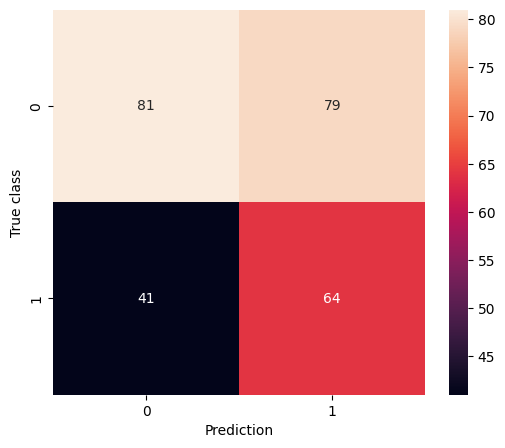

In [19]:
cm = confusion_matrix(message_val['burnout'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Ragequit - LR

sklearn

In [135]:
burnout_logistic_data = logistic_data[~logistic_data['ragequit_t+1'].isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'burnout', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data[['ragequit_t+1']])

In [136]:
burnout_logistic_data.describe(include = 'all')

,Avg. distance,Lone Wolf,Messages Sent,Organisational Silo,Radio Silence,standardized_workload,black_cloud,ragequit_t+1,st_congruence,reply_degree,reply_between,git_between,reply_density,git_density
count,175.000000,175,175.000000,175,175,175.000000,175,175,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
unique,NaN,2,NaN,2,2,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,True,NaN,False,True,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,143,NaN,115,122,NaN,127,169,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.210151,NaN,23.017143,NaN,NaN,1.083966,NaN,NaN,0.460369,0.361653,0.101272,0.271113,0.225617,0.360327
std,1.105669,NaN,20.549485,NaN,NaN,1.949013,NaN,NaN,0.152246,0.062051,0.041744,0.176916,0.087617,0.149198
min,1.000000,NaN,1.000000,NaN,NaN,0.003014,NaN,NaN,0.166667,0.259740,0.036511,0.000000,0.085990,0.163636
25%,1.414286,NaN,7.000000,NaN,NaN,0.129879,NaN,NaN,0.363636,0.312084,0.084242,0.151346,0.160155,0.200000
50%,2.000000,NaN,16.000000,NaN,NaN,0.423927,NaN,NaN,0.444444,0.374747,0.096191,0.222222,0.225306,0.425000
75%,2.666667,NaN,36.000000,NaN,NaN,1.352848,NaN,NaN,0.500000,0.427755,0.129434,0.326531,0.261616,0.500000


In [137]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+1', axis = 1), logistic_train_data['ragequit_t+1'])

Text(45.722222222222214, 0.5, 'True class')

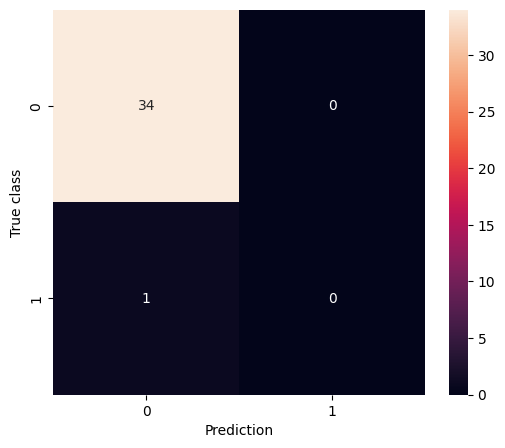

In [138]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], lr_model.predict(logistic_test_data.drop('ragequit_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [139]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+1'].astype(float), sm.add_constant(logistic_train_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence']]).astype(float)).fit(disp = 0)
stat_model.summary()

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+1   No. Observations:                  140
Model:                          Logit   Df Residuals:                      131
Method:                           MLE   Df Model:                            8
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.2543
Time:                        03:20:59   Log-Likelihood:                -16.085
converged:                      False   LL-Null:                       -21.571
Covariance Type:            nonrobust   LLR p-value:                    0.2033
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -25.0975   3.89e+05  -6.46e-05      1.000   -7.62e+05    7.62e+05
Avg. distance            -0.4960      0.558     -0.890      0.374      -1.589       0.597
Lone Wolf                 0.8499      1.489      0.571      0.568      -2.068       3.768
standardized_workload    -1.8122      1.656     -1.094      0.274      -5.059       1.434
Organisational Silo      -0.5012      1.336     -0.375      0.708      -3.120       2.118
Radio Silence            26.5740   3.89e+05   6.84e-05      1.000   -7.62e+05    7.62e+05
black_cloud               0.2889      1.078      0.268      0.789      -1.824       2.402
Messages Sent            -0.0162      0.049     -0.327      0.744      -0.113       0.081
st_congruence            -6.9078      5.144     -1.343      0.179     -16.989       3.174
=========================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Text(45.722222222222214, 0.5, 'True class')

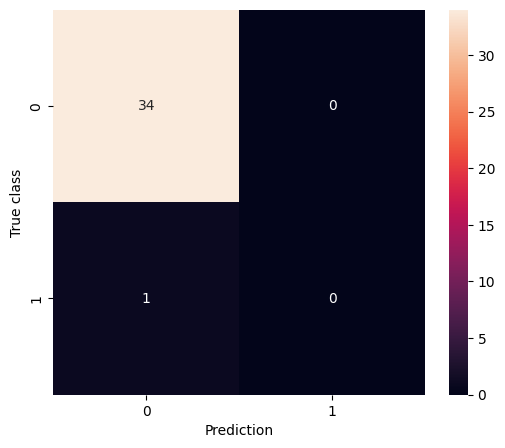

In [140]:
cm = confusion_matrix(logistic_test_data['ragequit_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data[['Avg. distance', 'Lone Wolf', 'standardized_workload',
 'Organisational Silo', 'Radio Silence',  'black_cloud', 'Messages Sent', 'st_congruence']]).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [20]:
message_data = all_test[['reply_body', 'ragequit_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+1'] = message_data['ragequit_t+1'].astype(bool)
message_data

100%|██████████| 5231/5231 [01:13<00:00, 71.48it/s] 


,reply_body,ragequit_t+1,lemmas
0,"specifically, you can appid = thu, may 19, 201...",False,"[specifically, appid, thu, sandesh, hegde]"
1,hi mostly within an operator -- things like ho...,False,"[hi, operator, thing, like, bufferserver, tupl..."
2,"the jira is here has all the fri, may 13, 2016...",False,"[jira, fri]"
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
...,...,...,...
6214,@tweise please review,False,[review]
6215,thanks you i will gothe approach the additiona...,False,"[thank, gothe, approach, additional, suggest, ..."
6216,the documentation is missing a between two wor...,False,"[documentation, miss, word, line]"
6218,the command shutdown-app now supports not only...,False,"[command, shutdown, app, commit, add, function..."


In [21]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if 3*message_train["ragequit_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        if message_train["ragequit_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+1"].sum()
        print(f'Positive cases: {message_train["ragequit_t+1"].sum()}')
        message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 3537
length of validation set: 759
length of test set: 759
Positive cases: 98
Positive cases: 294
New length of train set: 588


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1360335003.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1360335003.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [22]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                pos_importance  pos_occur  total_appearances
jan                   0.078740       10.0              127.0
partition             0.069652       14.0              201.0
output                0.068966       12.0              174.0
stream                0.067039       12.0              179.0
container             0.062857       11.0              175.0
send                  0.050000        7.0              140.0
tuple                 0.045455       17.0              374.0
port                  0.044944        8.0              178.0
currently             0.044248        5.0              113.0
implementation        0.044118        6.0              136.0
line                  0.042735        5.0              117.0
check                 0.041916        7.0              167.0
way                   0.041534       13.0              313.0
attribute             0.041379        6.0              145.0
start                 0.040816        6.0              147.0
thu         

In [23]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.99      0.73      0.84       744\n        True       0.04      0.60      0.08        15\n\n    accuracy                           0.73       759\n   macro avg       0.52      0.67      0.46       759\nweighted avg       0.97      0.73      0.83       759\n'

Text(45.722222222222214, 0.5, 'True class')

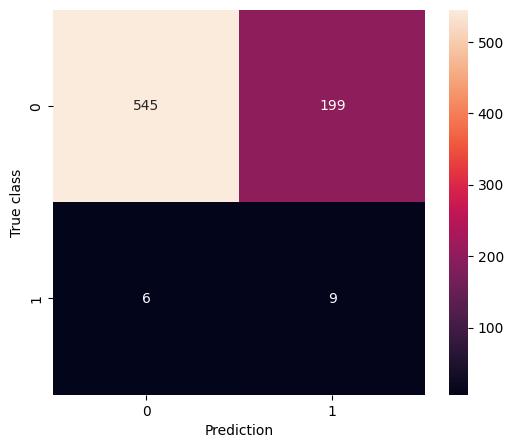

In [24]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [25]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.39      0.56       744\n        True       0.02      0.67      0.04        15\n\n    accuracy                           0.39       759\n   macro avg       0.50      0.53      0.30       759\nweighted avg       0.96      0.39      0.55       759\n'

Text(45.722222222222214, 0.5, 'True class')

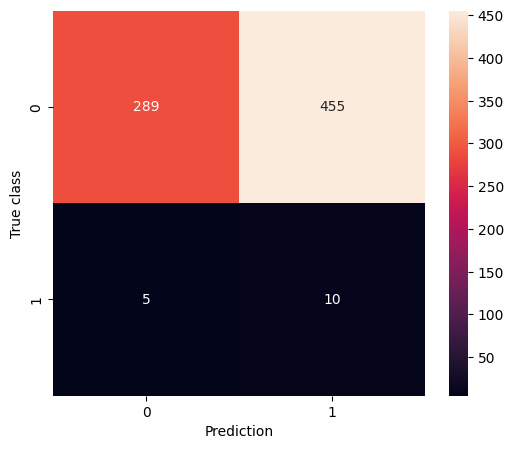

In [26]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [27]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.58      0.73       744\n        True       0.02      0.53      0.05        15\n\n    accuracy                           0.57       759\n   macro avg       0.50      0.55      0.39       759\nweighted avg       0.96      0.57      0.71       759\n'

Text(45.722222222222214, 0.5, 'True class')

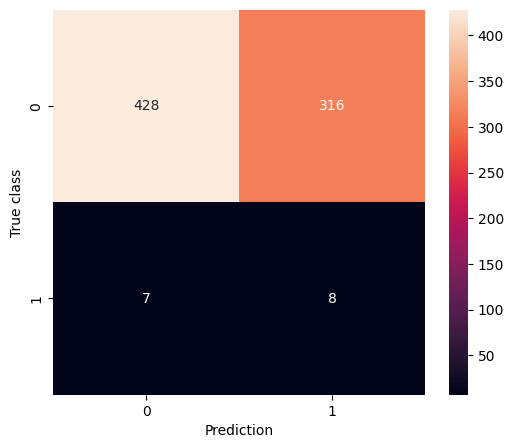

In [28]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [29]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.98      0.98      0.98       744\n        True       0.11      0.13      0.12        15\n\n    accuracy                           0.96       759\n   macro avg       0.54      0.56      0.55       759\nweighted avg       0.97      0.96      0.96       759\n'

Text(45.722222222222214, 0.5, 'True class')

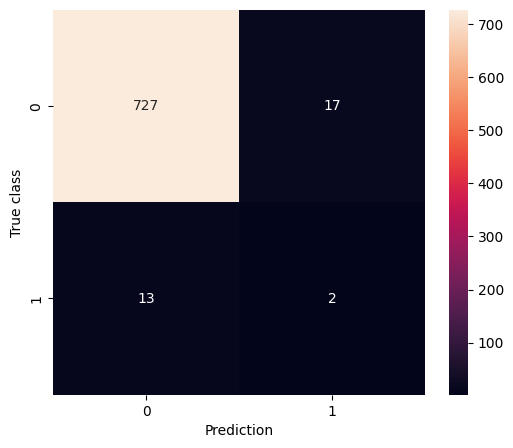

In [30]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [31]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_train.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.47      0.63       744\n        True       0.02      0.47      0.03        15\n\n    accuracy                           0.47       759\n   macro avg       0.50      0.47      0.33       759\nweighted avg       0.96      0.47      0.62       759\n'

Text(45.722222222222214, 0.5, 'True class')

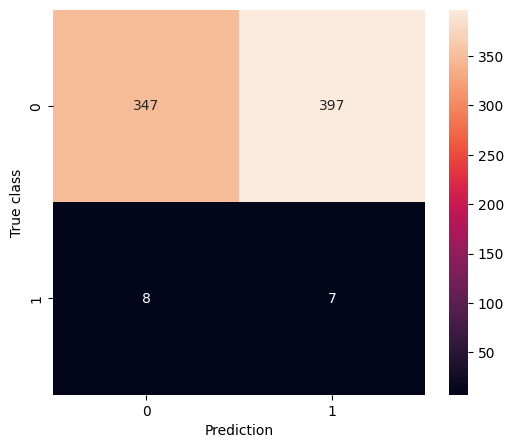

In [32]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [33]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+1'])

classification_report(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.98      0.99      0.99       744\n        True       0.00      0.00      0.00        15\n\n    accuracy                           0.97       759\n   macro avg       0.49      0.50      0.49       759\nweighted avg       0.96      0.97      0.97       759\n'

Text(45.722222222222214, 0.5, 'True class')

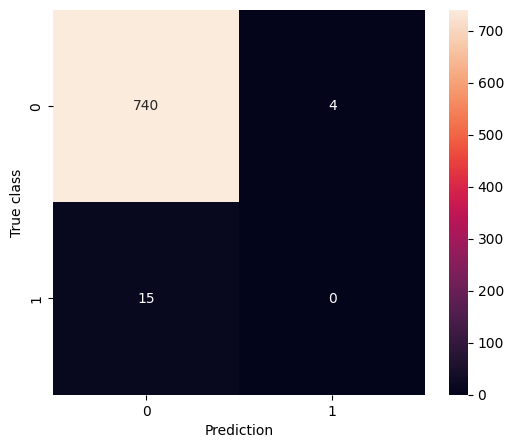

In [34]:
cm = confusion_matrix(message_val['ragequit_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# Lagged variables

## Burnout t+1

In [130]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+1':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+1'])


In [131]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+1', axis = 1), logistic_train_data['burnout_t+1'])

Text(45.722222222222214, 0.5, 'True class')

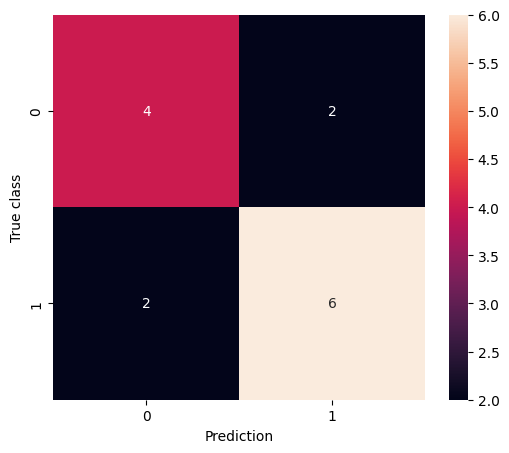

In [132]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], lr_model.predict(logistic_test_data.drop('burnout_t+1', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [133]:
stat_model = sm.Logit(logistic_train_data['burnout_t+1'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+1', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+1   No. Observations:                   55
Model:                          Logit   Df Residuals:                       41
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.2448
Time:                        03:20:58   Log-Likelihood:                -28.619
converged:                       True   LL-Null:                       -37.896
Covariance Type:            nonrobust   LLR p-value:                    0.1377
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1384      2.898     -0.048      0.962      -5.819       5.542
Avg. distance             0.3887      0.513      0.758      0.449      -0.617       1.394
Lone Wolf                -0.4068      1.229     -0.331      0.741      -2.817       2.003
Messages Sent             0.0245      0.022      1.095      0.273      -0.019       0.068
Organisational Silo       0.3602      0.836      0.431      0.667      -1.279       2.000
Radio Silence            -0.3754      0.969     -0.387      0.699      -2.276       1.525
standardized_workload    -1.4163      0.516     -2.746      0.006      -2.427      -0.405
black_cloud              -0.1875      0.853     -0.220      0.826      -1.860       1.485
st_congruence            -0.6516      3.609     -0.181      0.857      -7.725       6.422
reply_degree              5.8405     10.605      0.551      0.582     -14.944      26.625
reply_between           -10.3999     17.622     -0.590      0.555     -44.938      24.138
git_between               4.6373      3.227      1.437      0.151      -1.688      10.962
reply_density             1.0850      5.904      0.184      0.854     -10.486      12.656
git_density              -4.4573      3.232     -1.379      0.168     -10.791       1.877
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

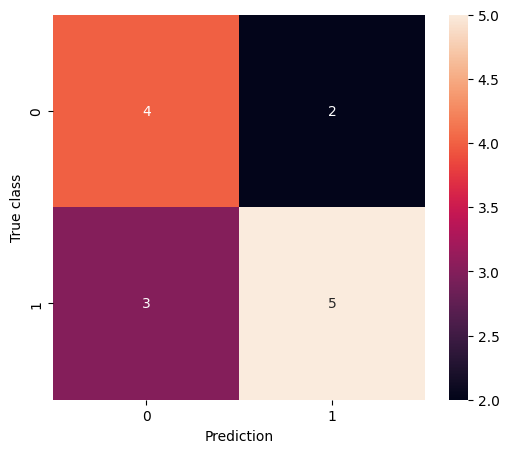

In [134]:
cm = confusion_matrix(logistic_test_data['burnout_t+1'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+1', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [35]:
message_data = all_test[['reply_body', 'burnout_t+1']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+1'] = message_data['burnout_t+1'].astype(bool)
message_data

100%|██████████| 2253/2253 [00:22<00:00, 99.96it/s] 


,reply_body,burnout_t+1,lemmas
1,hi mostly within an operator -- things like ho...,True,"[hi, operator, thing, like, bufferserver, tupl..."
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
5,i should have mentioned that i had a pull requ...,False,"[mention, pull, request, merge, correct, thu, ..."
6,i of please let me knowyou the idea behind of ...,True,"[let, knowyou, idea, constructor, say, recover..."
...,...,...,...
5834,custom ssl store propagation at application la...,False,"[custom, ssl, store, propagation, application,..."
5836,@pramodssimmaneni could you please reviewmerge ?,False,[reviewmerge]
6194,there are still some minor details that i want...,True,"[minor, detail, want, care, course, week]"
6204,- rebase @vrozov,True,[rebase]


In [36]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+1'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+1'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+1"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+1"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train['burnout_t+1']==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if 3*message_train["burnout_t+1"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+1"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+1"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        if message_train["burnout_t+1"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+1"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+1"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+1"].sum()
        print(f'Positive cases: {message_train["burnout_t+1"].sum()}')
        message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_13296\995443566.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages


length of train set: 1502
length of validation set: 323
length of test set: 323
Positive cases: 584
New length of train set: 1072


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\995443566.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+1").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [37]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+1']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+1']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
             pos_importance  pos_occur  total_appearances
user               0.647399      112.0              173.0
hi                 0.644737       98.0              152.0
fix                0.642276       79.0              123.0
pm                 0.640523       98.0              153.0
tuple              0.630252       75.0              119.0
add                0.615721      141.0              229.0
work               0.610619       69.0              113.0
nov                0.610390       94.0              154.0
use                0.590000      118.0              200.0
think              0.583784      108.0              185.0
thu                0.583333       77.0              132.0
application        0.574850       96.0              167.0
good               0.572816       59.0              103.0
want               0.544776       73.0              134.0
d                  0.544304       86.0              158.0
tue                0.542484       83.0              153.0
op

In [38]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.54      0.66      0.59       152\n        True       0.62      0.49      0.55       171\n\n    accuracy                           0.57       323\n   macro avg       0.58      0.58      0.57       323\nweighted avg       0.58      0.57      0.57       323\n'

Text(45.722222222222214, 0.5, 'True class')

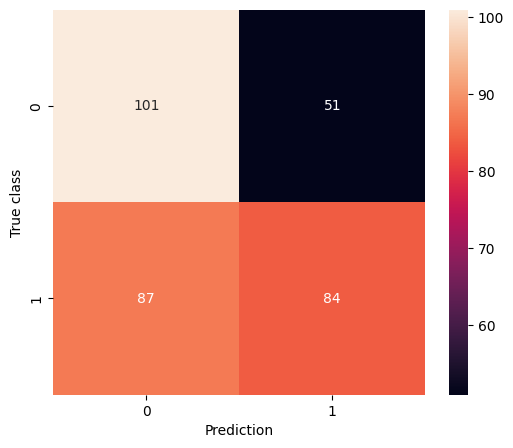

In [39]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [40]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.46      0.15      0.23       152\n        True       0.53      0.84      0.65       171\n\n    accuracy                           0.52       323\n   macro avg       0.49      0.50      0.44       323\nweighted avg       0.50      0.52      0.45       323\n'

Text(45.722222222222214, 0.5, 'True class')

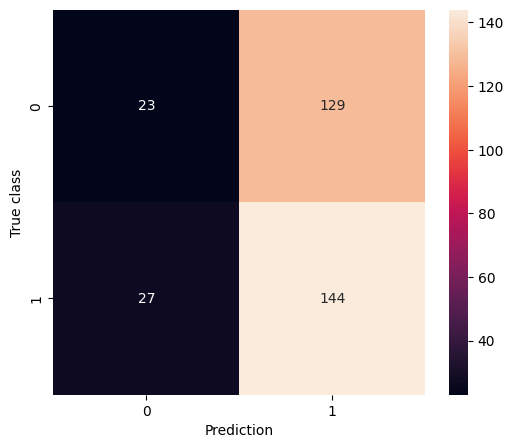

In [41]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [42]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.52      0.55      0.53       152\n        True       0.58      0.56      0.57       171\n\n    accuracy                           0.55       323\n   macro avg       0.55      0.55      0.55       323\nweighted avg       0.55      0.55      0.55       323\n'

Text(45.722222222222214, 0.5, 'True class')

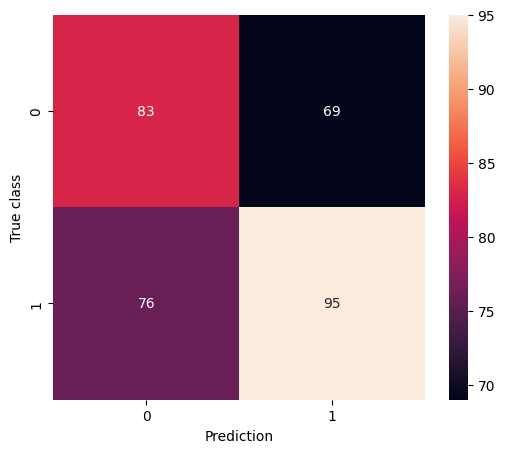

In [43]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [44]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.55      0.66      0.60       152\n        True       0.64      0.52      0.57       171\n\n    accuracy                           0.59       323\n   macro avg       0.59      0.59      0.59       323\nweighted avg       0.60      0.59      0.59       323\n'

Text(45.722222222222214, 0.5, 'True class')

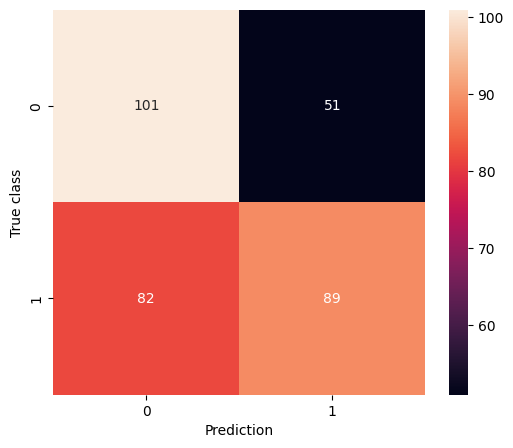

In [45]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [46]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.58      0.66      0.62       152\n        True       0.66      0.57      0.61       171\n\n    accuracy                           0.61       323\n   macro avg       0.62      0.62      0.61       323\nweighted avg       0.62      0.61      0.61       323\n'

Text(45.722222222222214, 0.5, 'True class')

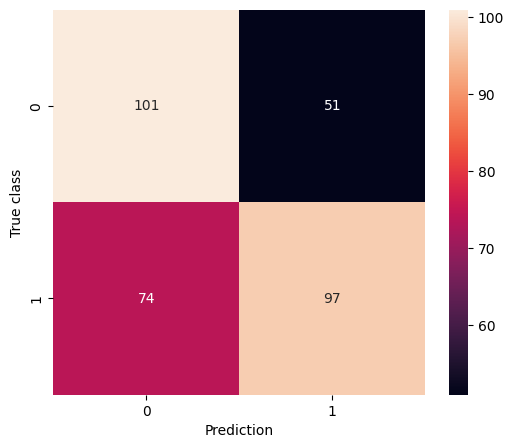

In [47]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [48]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+1'])

classification_report(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.54      0.57      0.55       152\n        True       0.60      0.56      0.58       171\n\n    accuracy                           0.57       323\n   macro avg       0.57      0.57      0.57       323\nweighted avg       0.57      0.57      0.57       323\n'

Text(45.722222222222214, 0.5, 'True class')

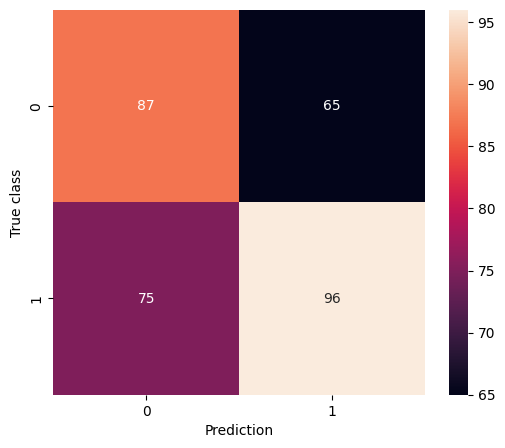

In [49]:
cm = confusion_matrix(message_val['burnout_t+1'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout_t+3

In [125]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+3'])


In [126]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+3', axis = 1), logistic_train_data['burnout_t+3'])

Text(45.722222222222214, 0.5, 'True class')

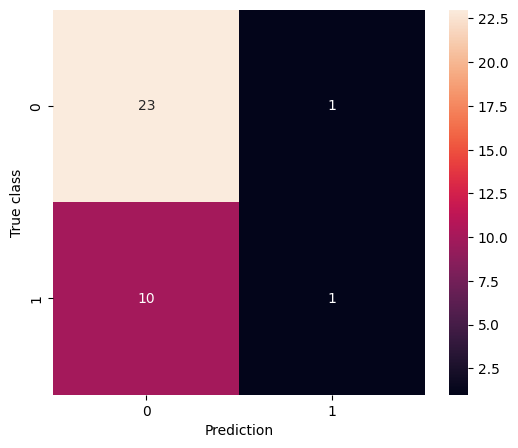

In [127]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], lr_model.predict(logistic_test_data.drop('burnout_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [128]:
stat_model = sm.Logit(logistic_train_data['burnout_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            burnout_t+3   No. Observations:                  140
Model:                          Logit   Df Residuals:                      126
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1548
Time:                        03:20:57   Log-Likelihood:                -74.921
converged:                       True   LL-Null:                       -88.643
Covariance Type:            nonrobust   LLR p-value:                   0.01081
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.3146      1.751     -1.893      0.058      -6.746       0.116
Avg. distance             0.5460      0.263      2.076      0.038       0.031       1.061
Lone Wolf                -2.1031      0.725     -2.899      0.004      -3.525      -0.681
Messages Sent             0.0302      0.012      2.628      0.009       0.008       0.053
Organisational Silo      -0.0204      0.493     -0.041      0.967      -0.986       0.945
Radio Silence            -0.1302      0.512     -0.254      0.799      -1.134       0.873
standardized_workload     0.0563      0.088      0.642      0.521      -0.115       0.228
black_cloud               0.6365      0.530      1.200      0.230      -0.403       1.676
st_congruence             0.8090      1.820      0.444      0.657      -2.759       4.377
reply_degree              2.7754      5.654      0.491      0.623      -8.305      13.856
reply_between            -2.2564      9.655     -0.234      0.815     -21.181      16.668
git_between              -0.8856      1.478     -0.599      0.549      -3.783       2.012
reply_density             2.4349      3.665      0.664      0.506      -4.748       9.618
git_density               2.0571      1.541      1.335      0.182      -0.963       5.078
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

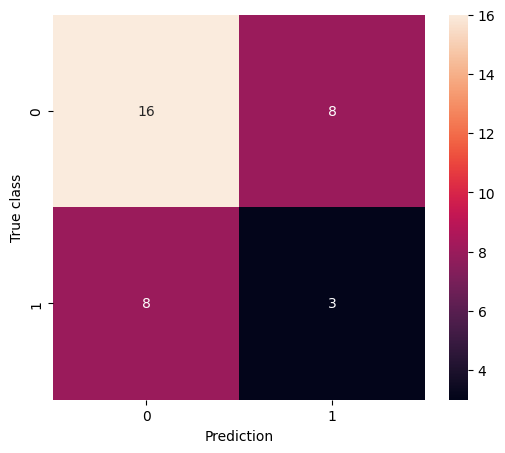

In [129]:
cm = confusion_matrix(logistic_test_data['burnout_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [50]:
message_data = all_test[['reply_body', 'burnout_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+3'] = message_data['burnout_t+3'].astype(bool)
message_data

100%|██████████| 5231/5231 [01:03<00:00, 82.36it/s] 


,reply_body,burnout_t+3,lemmas
0,"specifically, you can appid = thu, may 19, 201...",False,"[specifically, appid, thu, sandesh, hegde]"
1,hi mostly within an operator -- things like ho...,True,"[hi, operator, thing, like, bufferserver, tupl..."
2,"the jira is here has all the fri, may 13, 2016...",False,"[jira, fri]"
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
...,...,...,...
6214,@tweise please review,False,[review]
6215,thanks you i will gothe approach the additiona...,False,"[thank, gothe, approach, additional, suggest, ..."
6216,the documentation is missing a between two wor...,True,"[documentation, miss, word, line]"
6218,the command shutdown-app now supports not only...,True,"[command, shutdown, app, commit, add, function..."


In [51]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if 3*message_train["burnout_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        if message_train["burnout_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+3"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+3"].sum()
        print(f'Positive cases: {message_train["burnout_t+3"].sum()}')
        message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1913014158.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages


length of train set: 3537
length of validation set: 759
length of test set: 759
Positive cases: 936
New length of train set: 1872


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\1913014158.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [52]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                pos_importance  pos_occur  total_appearances
nov                   0.645000      129.0              200.0
dec                   0.638462       83.0              130.0
pm                    0.570312      146.0              256.0
jan                   0.551181       70.0              127.0
vote                  0.548387       85.0              155.0
tue                   0.538462      133.0              247.0
thu                   0.530172      123.0              232.0
mon                   0.527094      107.0              203.0
sep                   0.517442       89.0              172.0
line                  0.504274       59.0              117.0
fri                   0.500000       82.0              164.0
block                 0.490385       51.0              104.0
attribute             0.489655       71.0              145.0
reviewmerge           0.488372       63.0              129.0
hi                    0.486755      147.0              302.0
pull        

In [53]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.78      0.58      0.67       496\n        True       0.47      0.70      0.56       263\n\n    accuracy                           0.62       759\n   macro avg       0.63      0.64      0.61       759\nweighted avg       0.67      0.62      0.63       759\n'

Text(45.722222222222214, 0.5, 'True class')

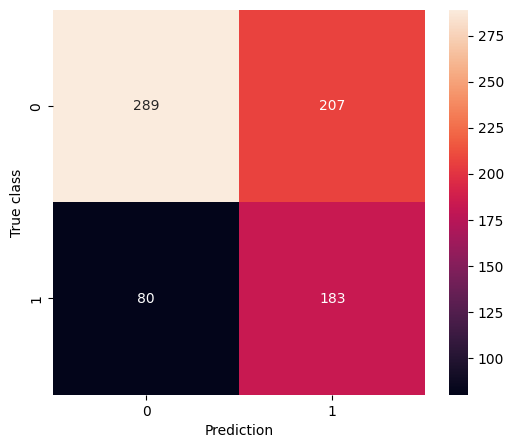

In [54]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [55]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.71      0.61      0.66       496\n        True       0.42      0.53      0.47       263\n\n    accuracy                           0.58       759\n   macro avg       0.56      0.57      0.56       759\nweighted avg       0.61      0.58      0.59       759\n'

Text(45.722222222222214, 0.5, 'True class')

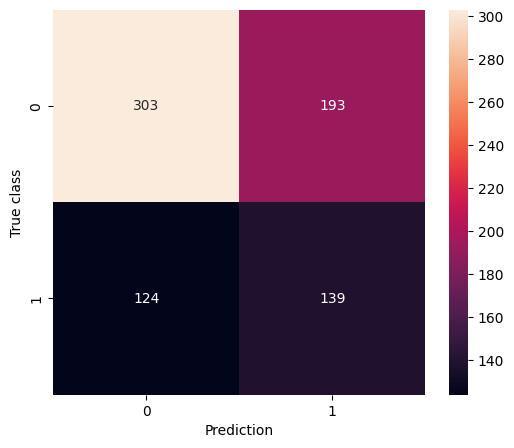

In [56]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [57]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.72      0.68      0.70       496\n        True       0.45      0.50      0.47       263\n\n    accuracy                           0.61       759\n   macro avg       0.58      0.59      0.58       759\nweighted avg       0.62      0.61      0.62       759\n'

Text(45.722222222222214, 0.5, 'True class')

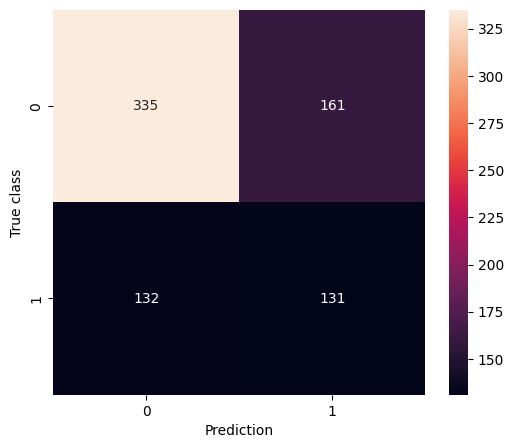

In [58]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [59]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.76      0.67      0.72       496\n        True       0.50      0.60      0.54       263\n\n    accuracy                           0.65       759\n   macro avg       0.63      0.64      0.63       759\nweighted avg       0.67      0.65      0.66       759\n'

Text(45.722222222222214, 0.5, 'True class')

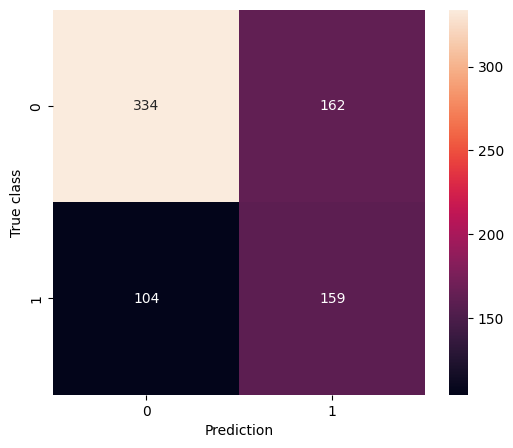

In [60]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [61]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.76      0.64      0.69       496\n        True       0.48      0.62      0.54       263\n\n    accuracy                           0.63       759\n   macro avg       0.62      0.63      0.62       759\nweighted avg       0.66      0.63      0.64       759\n'

Text(45.722222222222214, 0.5, 'True class')

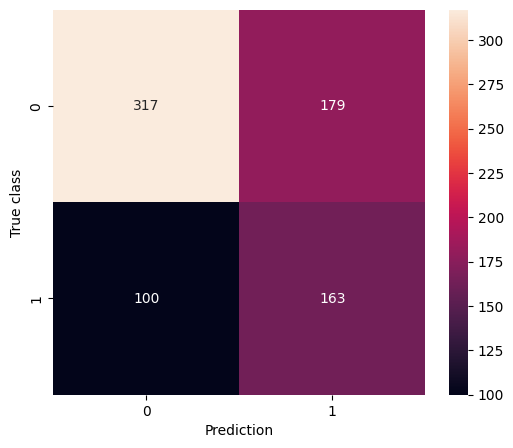

In [62]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [63]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+3'])

classification_report(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.76      0.65      0.70       496\n        True       0.48      0.60      0.53       263\n\n    accuracy                           0.64       759\n   macro avg       0.62      0.63      0.62       759\nweighted avg       0.66      0.64      0.64       759\n'

Text(45.722222222222214, 0.5, 'True class')

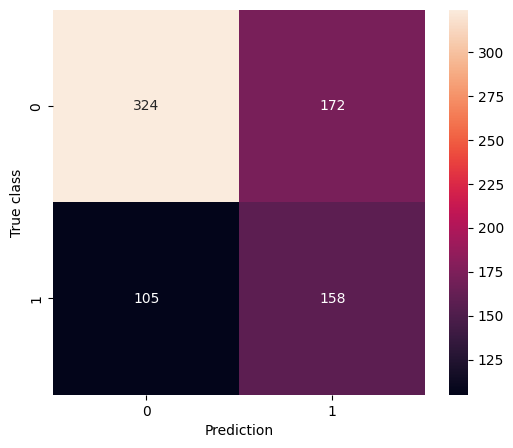

In [64]:
cm = confusion_matrix(message_val['burnout_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Burnout T+12

In [120]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout', 'ragequit_t+1', 'ragequit_t+3', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'burnout_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['burnout_t+12'])


In [121]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('burnout_t+12', axis = 1), logistic_train_data['burnout_t+12'])

Text(45.722222222222214, 0.5, 'True class')

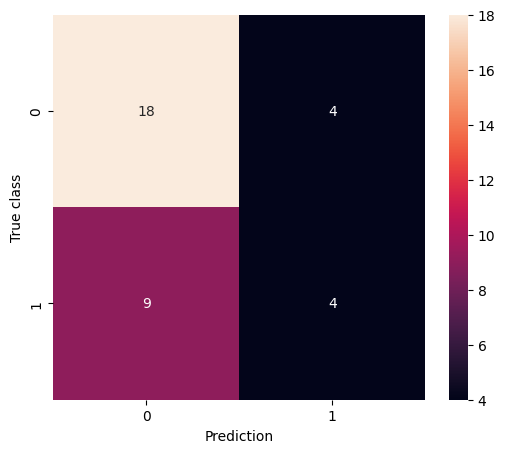

In [122]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], lr_model.predict(logistic_test_data.drop('burnout_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [123]:
stat_model = sm.Logit(logistic_train_data['burnout_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('burnout_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           burnout_t+12   No. Observations:                  140
Model:                          Logit   Df Residuals:                      126
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1243
Time:                        03:20:56   Log-Likelihood:                -80.402
converged:                       True   LL-Null:                       -91.818
Covariance Type:            nonrobust   LLR p-value:                   0.04373
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.9496      1.825     -2.164      0.030      -7.527      -0.372
Avg. distance             0.2233      0.240      0.932      0.351      -0.246       0.693
Lone Wolf                -0.9588      0.654     -1.467      0.142      -2.240       0.322
Messages Sent             0.0205      0.012      1.712      0.087      -0.003       0.044
Organisational Silo       0.2302      0.491      0.469      0.639      -0.731       1.192
Radio Silence             0.4784      0.499      0.959      0.337      -0.499       1.456
standardized_workload     0.0531      0.091      0.586      0.558      -0.125       0.231
black_cloud               0.1294      0.522      0.248      0.804      -0.894       1.153
st_congruence             0.3110      1.767      0.176      0.860      -3.152       3.774
reply_degree              5.6118      5.519      1.017      0.309      -5.205      16.429
reply_between            -2.9038      9.086     -0.320      0.749     -20.712      14.905
git_between              -1.5463      1.467     -1.054      0.292      -4.421       1.328
reply_density             2.7374      3.321      0.824      0.410      -3.772       9.246
git_density               1.3856      1.485      0.933      0.351      -1.525       4.297
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

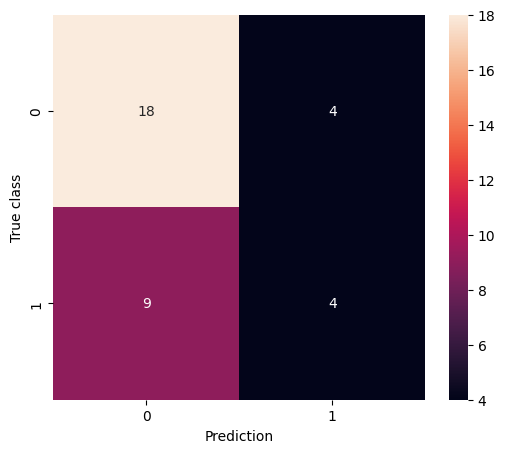

In [124]:
cm = confusion_matrix(logistic_test_data['burnout_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('burnout_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [65]:
message_data = all_test[['reply_body', 'burnout_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['burnout_t+12'] = message_data['burnout_t+12'].astype(bool)
message_data

100%|██████████| 5231/5231 [01:06<00:00, 78.35it/s] 


,reply_body,burnout_t+12,lemmas
0,"specifically, you can appid = thu, may 19, 201...",False,"[specifically, appid, thu, sandesh, hegde]"
1,hi mostly within an operator -- things like ho...,True,"[hi, operator, thing, like, bufferserver, tupl..."
2,"the jira is here has all the fri, may 13, 2016...",False,"[jira, fri]"
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
...,...,...,...
6214,@tweise please review,False,[review]
6215,thanks you i will gothe approach the additiona...,False,"[thank, gothe, approach, additional, suggest, ..."
6216,the documentation is missing a between two wor...,True,"[documentation, miss, word, line]"
6218,the command shutdown-app now supports not only...,True,"[command, shutdown, app, commit, add, function..."


In [66]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['burnout_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['burnout_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["burnout_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["burnout_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if 3*message_train["burnout_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["burnout_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["burnout_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        if message_train["burnout_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["burnout_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["burnout_t+12"].sum()}')

        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["burnout_t+12"].sum()
        print(f'Positive cases: {message_train["burnout_t+12"].sum()}')
        message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

C:\Users\woute\AppData\Local\Temp\ipykernel_13296\188543492.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages


length of train set: 3537
length of validation set: 759
length of test set: 759
Positive cases: 1024
New length of train set: 2048


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\188543492.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("burnout_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [67]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['burnout_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['burnout_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
                pos_importance  pos_occur  total_appearances
â                     0.969925      129.0              133.0
sep                   0.703488      121.0              172.0
nov                   0.665000      133.0              200.0
dec                   0.646154       84.0              130.0
property              0.630769      123.0              195.0
vote                  0.593548       92.0              155.0
pm                    0.589844      151.0              256.0
tue                   0.574899      142.0              247.0
thu                   0.573276      133.0              232.0
line                  0.572650       67.0              117.0
mon                   0.556650      113.0              203.0
request               0.553785      139.0              251.0
jan                   0.551181       70.0              127.0
reviewmerge           0.527132       68.0              129.0
fri                   0.524390       86.0              164.0
pull        

In [68]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.77      0.69      0.73       473\n        True       0.57      0.66      0.61       286\n\n    accuracy                           0.68       759\n   macro avg       0.67      0.68      0.67       759\nweighted avg       0.69      0.68      0.68       759\n'

Text(45.722222222222214, 0.5, 'True class')

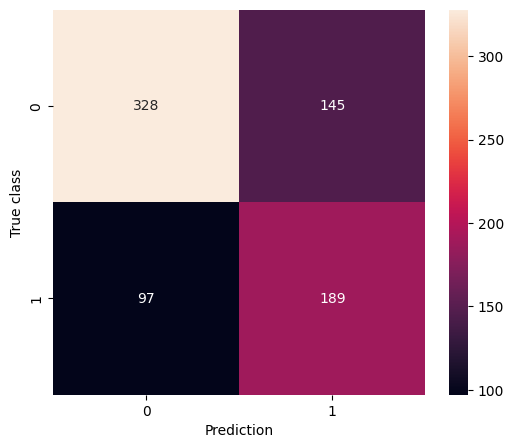

In [69]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [70]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.69      0.75      0.72       473\n        True       0.51      0.44      0.47       286\n\n    accuracy                           0.63       759\n   macro avg       0.60      0.59      0.59       759\nweighted avg       0.62      0.63      0.62       759\n'

Text(45.722222222222214, 0.5, 'True class')

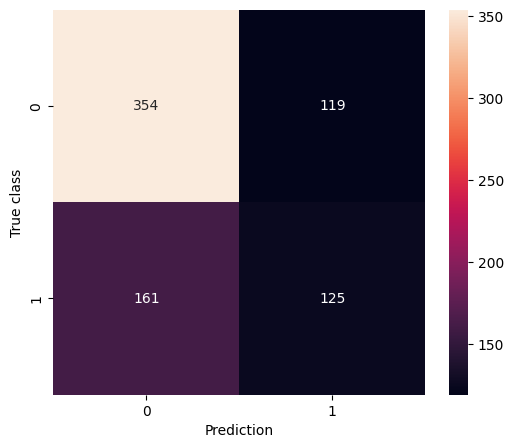

In [71]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [72]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.68      0.66      0.67       473\n        True       0.46      0.48      0.47       286\n\n    accuracy                           0.59       759\n   macro avg       0.57      0.57      0.57       759\nweighted avg       0.60      0.59      0.59       759\n'

Text(45.722222222222214, 0.5, 'True class')

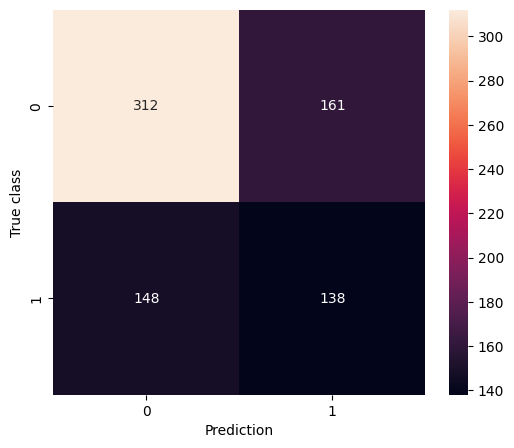

In [73]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [74]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.74      0.72      0.73       473\n        True       0.56      0.59      0.58       286\n\n    accuracy                           0.67       759\n   macro avg       0.65      0.66      0.65       759\nweighted avg       0.68      0.67      0.67       759\n'

Text(45.722222222222214, 0.5, 'True class')

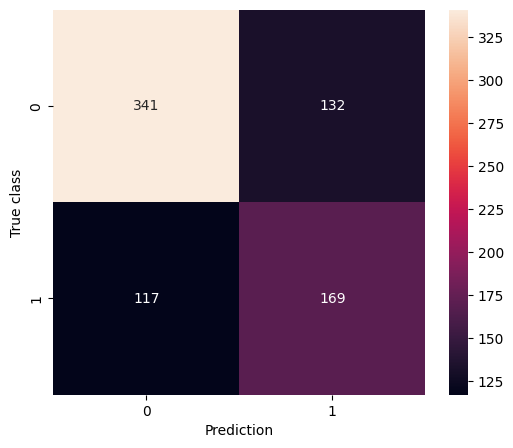

In [75]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [76]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.74      0.54      0.63       473\n        True       0.47      0.68      0.56       286\n\n    accuracy                           0.60       759\n   macro avg       0.61      0.61      0.59       759\nweighted avg       0.64      0.60      0.60       759\n'

Text(45.722222222222214, 0.5, 'True class')

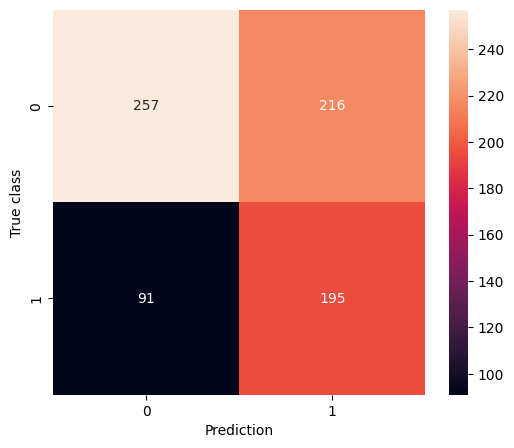

In [77]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [78]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['burnout_t+12'])

classification_report(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.71      0.66      0.68       473\n        True       0.50      0.55      0.52       286\n\n    accuracy                           0.62       759\n   macro avg       0.60      0.61      0.60       759\nweighted avg       0.63      0.62      0.62       759\n'

Text(45.722222222222214, 0.5, 'True class')

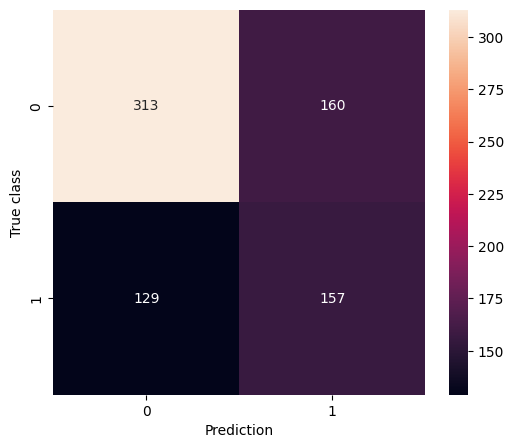

In [79]:
cm = confusion_matrix(message_val['burnout_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+3

In [115]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'burnout', 'ragequit_t+12', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'Workload'], axis = 1).dropna().astype({'ragequit_t+3':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+3'])


In [116]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+3', axis = 1), logistic_train_data['ragequit_t+3'])

Text(45.722222222222214, 0.5, 'True class')

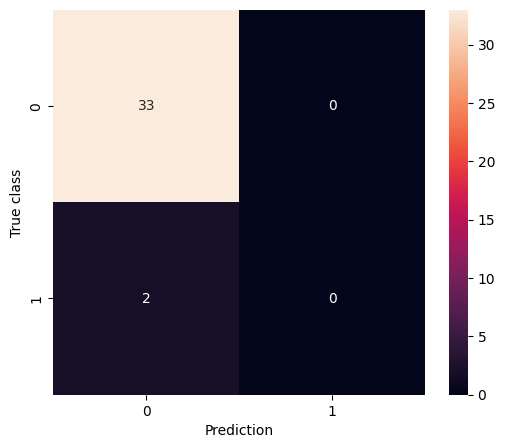

In [117]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], lr_model.predict(logistic_test_data.drop('ragequit_t+3', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [118]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+3'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+3', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           ragequit_t+3   No. Observations:                  140
Model:                          Logit   Df Residuals:                      125
Method:                           MLE   Df Model:                           14
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1640
Time:                        03:20:55   Log-Likelihood:                -25.637
converged:                       True   LL-Null:                       -30.665
Covariance Type:            nonrobust   LLR p-value:                    0.7582
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.4853      3.785     -0.128      0.898      -7.904       6.933
Avg. distance             0.0430      0.446      0.097      0.923      -0.831       0.917
Lone Wolf                -1.0873      1.315     -0.827      0.408      -3.664       1.490
Messages Sent             0.0006      0.031      0.020      0.984      -0.059       0.061
Organisational Silo       0.5898      1.264      0.467      0.641      -1.887       3.067
Radio Silence            -0.0318      1.050     -0.030      0.976      -2.090       2.027
standardized_workload    -0.5944      0.657     -0.905      0.365      -1.881       0.692
black_cloud               1.3678      1.063      1.287      0.198      -0.715       3.451
st_congruence            -0.2900      4.343     -0.067      0.947      -8.802       8.222
reply_degree            -20.1448     14.376     -1.401      0.161     -48.321       8.032
reply_between            37.4346     21.225      1.764      0.078      -4.165      79.034
git_degree                5.7494      7.128      0.807      0.420      -8.220      19.719
git_between              -6.2336      4.326     -1.441      0.150     -14.712       2.245
reply_density             9.4755      7.524      1.259      0.208      -5.272      24.223
git_density              -2.8656      4.064     -0.705      0.481     -10.831       5.100
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

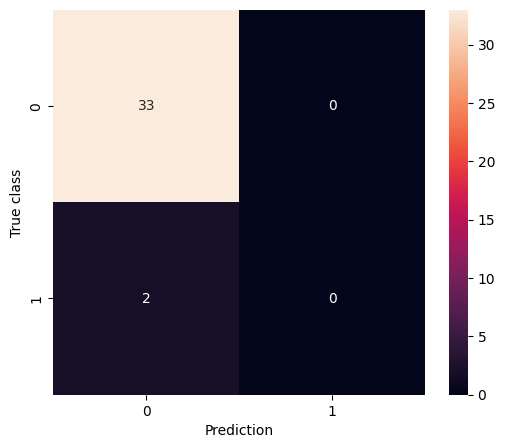

In [119]:
cm = confusion_matrix(logistic_test_data['ragequit_t+3'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+3', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [80]:
message_data = all_test[['reply_body', 'ragequit_t+3']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+3'] = message_data['ragequit_t+3'].astype(bool)
message_data

100%|██████████| 5231/5231 [00:51<00:00, 101.72it/s]


,reply_body,ragequit_t+3,lemmas
0,"specifically, you can appid = thu, may 19, 201...",False,"[specifically, appid, thu, sandesh, hegde]"
1,hi mostly within an operator -- things like ho...,False,"[hi, operator, thing, like, bufferserver, tupl..."
2,"the jira is here has all the fri, may 13, 2016...",False,"[jira, fri]"
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
...,...,...,...
6214,@tweise please review,False,[review]
6215,thanks you i will gothe approach the additiona...,False,"[thank, gothe, approach, additional, suggest, ..."
6216,the documentation is missing a between two wor...,False,"[documentation, miss, word, line]"
6218,the command shutdown-app now supports not only...,False,"[command, shutdown, app, commit, add, function..."


In [81]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+3'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+3'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+3"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+3"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if 3*message_train["ragequit_t+3"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+3"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        if message_train["ragequit_t+3"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+3"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+3"].sum()
        print(f'Positive cases: {message_train["ragequit_t+3"].sum()}')
        message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 3537
length of validation set: 759
length of test set: 759
Positive cases: 374
Positive cases: 1122
New length of train set: 2244


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\3232222597.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_13296\3232222597.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+3").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [82]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+3']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+3']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
            pos_importance  pos_occur  total_appearances
info              0.348214       39.0              112.0
license           0.327103       35.0              107.0
update            0.195122       32.0              164.0
branch            0.181102       23.0              127.0
checkpoint        0.156463       23.0              147.0
app               0.154255       29.0              188.0
test              0.152406       57.0              374.0
master            0.148148       20.0              135.0
container         0.142857       25.0              175.0
unit              0.140000       21.0              150.0
come              0.137255       14.0              102.0
nov               0.135000       27.0              200.0
sep               0.133721       23.0              172.0
window            0.132832       53.0              399.0
dec               0.130769       17.0              130.0
log               0.130435       18.0              138.0
stream            0

In [83]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.96      0.69      0.81       708\n        True       0.12      0.57      0.20        51\n\n    accuracy                           0.69       759\n   macro avg       0.54      0.63      0.50       759\nweighted avg       0.90      0.69      0.76       759\n'

Text(45.722222222222214, 0.5, 'True class')

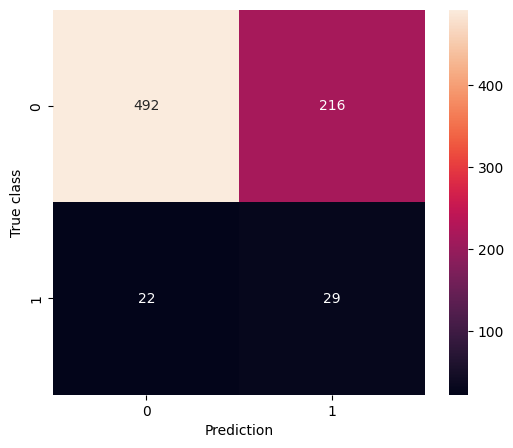

In [84]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [85]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.95      0.51      0.66       708\n        True       0.08      0.59      0.14        51\n\n    accuracy                           0.52       759\n   macro avg       0.51      0.55      0.40       759\nweighted avg       0.89      0.52      0.63       759\n'

Text(45.722222222222214, 0.5, 'True class')

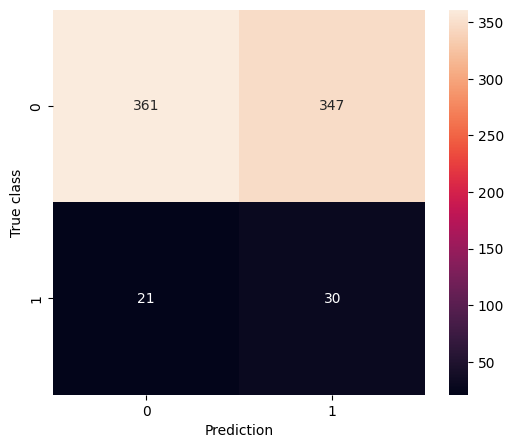

In [86]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [87]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.96      0.70      0.81       708\n        True       0.12      0.57      0.20        51\n\n    accuracy                           0.69       759\n   macro avg       0.54      0.63      0.50       759\nweighted avg       0.90      0.69      0.77       759\n'

Text(45.722222222222214, 0.5, 'True class')

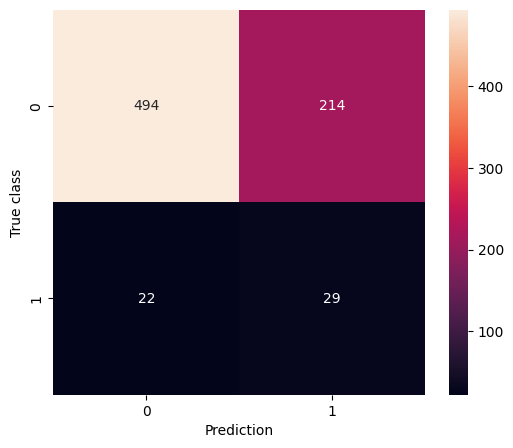

In [88]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [89]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.94      0.98      0.96       708\n        True       0.18      0.06      0.09        51\n\n    accuracy                           0.92       759\n   macro avg       0.56      0.52      0.52       759\nweighted avg       0.88      0.92      0.90       759\n'

Text(45.722222222222214, 0.5, 'True class')

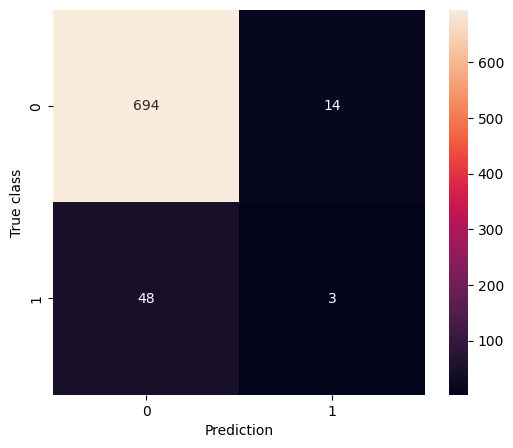

In [90]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [91]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.94      0.98      0.96       708\n        True       0.35      0.12      0.18        51\n\n    accuracy                           0.93       759\n   macro avg       0.65      0.55      0.57       759\nweighted avg       0.90      0.93      0.91       759\n'

Text(45.722222222222214, 0.5, 'True class')

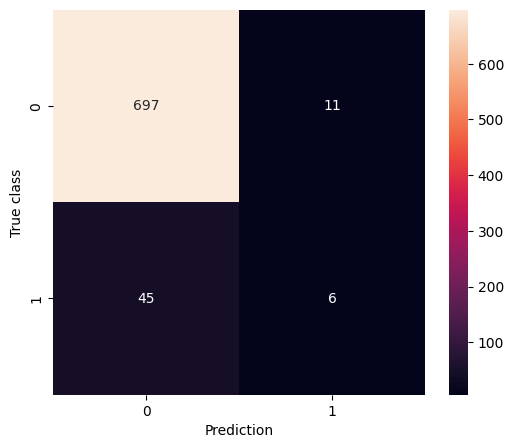

In [92]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [93]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+3'])

classification_report(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.94      1.00      0.97       708\n        True       0.50      0.06      0.11        51\n\n    accuracy                           0.93       759\n   macro avg       0.72      0.53      0.54       759\nweighted avg       0.91      0.93      0.91       759\n'

Text(45.722222222222214, 0.5, 'True class')

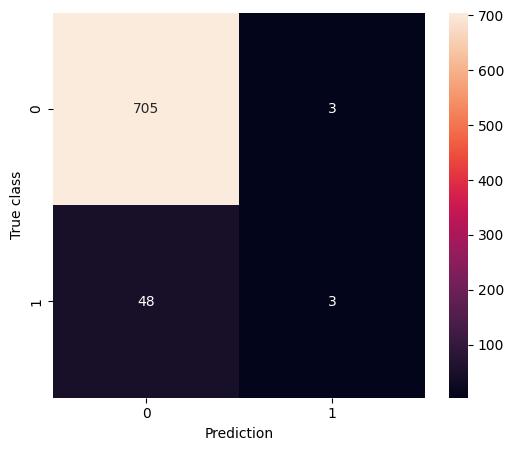

In [94]:
cm = confusion_matrix(message_val['ragequit_t+3'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

## Ragequit T+12

In [110]:
burnout_logistic_data = logistic_data[~logistic_data.burnout.isna()].drop(['burnout_t+1', 'burnout_t+3', 'burnout_t+12', 'ragequit_t+1', 'ragequit_t+3', 'burnout', 'git_close'], axis = 1).drop_duplicates().drop(['Alias', 'From', 'To', 'start_datetime', 'end_datetime', 'lagged_burnout', 'reply_close', 'working_months', 'quit', 'first_quit_month', 'git_degree', 'Workload'], axis = 1).dropna().astype({'ragequit_t+12':bool})
logistic_train_data, logistic_test_data = train_test_split(burnout_logistic_data, test_size = 0.2, random_state = 404, stratify = burnout_logistic_data['ragequit_t+12'])


In [111]:
lr_model = LogisticRegressionCV(max_iter = 1000000).fit(logistic_train_data.drop('ragequit_t+12', axis = 1), logistic_train_data['ragequit_t+12'])

Text(45.722222222222214, 0.5, 'True class')

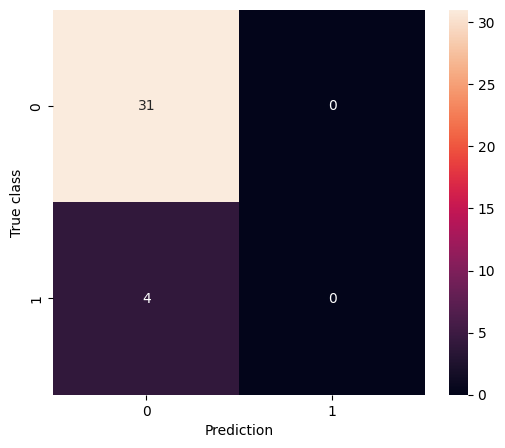

In [112]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], lr_model.predict(logistic_test_data.drop('ragequit_t+12', axis = 1)))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

statsmodels

In [113]:
stat_model = sm.Logit(logistic_train_data['ragequit_t+12'].astype(float), sm.add_constant(logistic_train_data.drop('ragequit_t+12', axis = 1)).astype(float)).fit(disp = 0)
stat_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          ragequit_t+12   No. Observations:                  140
Model:                          Logit   Df Residuals:                      126
Method:                           MLE   Df Model:                           13
Date:                Thu, 29 May 2025   Pseudo R-squ.:                  0.1143
Time:                        03:20:55   Log-Likelihood:                -44.068
converged:                       True   LL-Null:                       -49.754
Covariance Type:            nonrobust   LLR p-value:                    0.5797
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.4139      2.501     -0.965      0.334      -7.316       2.488
Avg. distance            -0.2898      0.343     -0.845      0.398      -0.962       0.382
Lone Wolf                 0.8492      0.996      0.852      0.394      -1.103       2.802
Messages Sent            -0.0185      0.024     -0.786      0.432      -0.065       0.028
Organisational Silo       0.9502      0.808      1.177      0.239      -0.633       2.533
Radio Silence             1.0304      0.734      1.403      0.161      -0.409       2.470
standardized_workload    -0.2950      0.332     -0.889      0.374      -0.945       0.355
black_cloud              -0.9779      0.917     -1.067      0.286      -2.775       0.819
st_congruence             2.8121      2.891      0.973      0.331      -2.854       8.478
reply_degree             -9.7608      7.805     -1.251      0.211     -25.059       5.537
reply_between            17.4494     13.590      1.284      0.199      -9.187      44.085
git_between              -1.1412      2.116     -0.539      0.590      -5.288       3.006
reply_density             1.9837      5.118      0.388      0.698      -8.047      12.015
git_density               0.7684      2.273      0.338      0.735      -3.686       5.223
=========================================================================================
"""

Text(45.722222222222214, 0.5, 'True class')

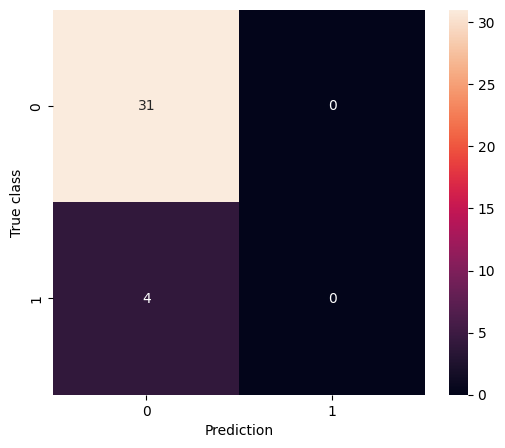

In [114]:
cm = confusion_matrix(logistic_test_data['ragequit_t+12'], round(stat_model.predict(sm.add_constant(logistic_test_data.drop('ragequit_t+12', axis = 1)).astype(float))).astype(int))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

### Burnout NB

In [95]:
message_data = all_test[['reply_body', 'ragequit_t+12']].dropna()

nlp = spacy.load('en_core_web_sm')
tqdm.pandas()

message_data['lemmas'] = message_data.reply_body.progress_apply(lambda x: [token.lemma_ for token in nlp(handle_negation(x)) if not token.is_stop and token.is_alpha])
message_data['ragequit_t+12'] = message_data['ragequit_t+12'].astype(bool)
message_data

100%|██████████| 5231/5231 [00:49<00:00, 106.65it/s]


,reply_body,ragequit_t+12,lemmas
0,"specifically, you can appid = thu, may 19, 201...",False,"[specifically, appid, thu, sandesh, hegde]"
1,hi mostly within an operator -- things like ho...,False,"[hi, operator, thing, like, bufferserver, tupl..."
2,"the jira is here has all the fri, may 13, 2016...",False,"[jira, fri]"
3,"-d - PositiveSentiment fri, 19 feb 2016 fri, 1...",False,"[PositiveSentiment, fri, feb, fri, feb, fri, f..."
4,do not think you can re-use an old app do not ...,False,"[use, old, app, good, idea, evenit, possible, ..."
...,...,...,...
6214,@tweise please review,False,[review]
6215,thanks you i will gothe approach the additiona...,False,"[thank, gothe, approach, additional, suggest, ..."
6216,the documentation is missing a between two wor...,False,"[documentation, miss, word, line]"
6218,the command shutdown-app now supports not only...,False,"[command, shutdown, app, commit, add, function..."


In [96]:
message_data = message_data[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 0]

message_train, message_test = train_test_split(message_data, test_size=0.15, random_state=404, stratify = message_data['ragequit_t+12'])
message_train, message_val = train_test_split(message_train, test_size=(0.15/0.85), random_state=404, stratify = message_train['ragequit_t+12'])

print(f'length of train set: {len(message_train)}\nlength of validation set: {len(message_val)}\nlength of test set: {len(message_test)}')
message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages

# Oversample on the True cases in the train set
if 2*message_train["ragequit_t+12"].sum()<len(message_train):
   # True is the minority class
    if 3*message_train["ragequit_t+12"].sum()<len(message_train):
        # We need to over- and undersample to create balance
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if 3*message_train["ragequit_t+12"].sum()<len(message_train):
            # Check for massive imbalance
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==1].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')
    else:
        nMax = message_train["ragequit_t+12"].sum()
        # Only undersampling will do
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')


else:
    if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
        # False is the minority class and we need to over- and undersample
        message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        if message_train["ragequit_t+12"].sum()>0.67*len(message_train):
            # Check for massive imbalance (mainly ragequit case)
            message_train = pd.concat([message_train.loc[message_train[message_train["ragequit_t+12"]==0].index], message_train])
            print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')

        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

    else:
        nMax = len(message_train) - message_train["ragequit_t+12"].sum()
        print(f'Positive cases: {message_train["ragequit_t+12"].sum()}')
        message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)

        print(f'New length of train set: {len(message_train)}')

length of train set: 3537
length of validation set: 759
length of test set: 759
Positive cases: 682
Positive cases: 2046
New length of train set: 4092


C:\Users\woute\AppData\Local\Temp\ipykernel_13296\2668262174.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  message_train = message_train[message_data.apply(lambda x: len(x.lemmas), axis = 1) > 3] # remove shorter messages
C:\Users\woute\AppData\Local\Temp\ipykernel_13296\2668262174.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  message_train = message_train.groupby("ragequit_t+12").apply(lambda x: x.sample(n=min(nMax, len(x)))).reset_index(drop = True).sample(frac=1)


In [97]:
pos_labels, pos_values = zip(*Counter(itertools.chain(*message_data[message_data['ragequit_t+12']].lemmas.tolist())).items())
neg_labels, neg_values = zip(*Counter(itertools.chain(*message_data[~message_data['ragequit_t+12']].lemmas.tolist())).items())

importance_df = pd.DataFrame(index = list(set(pos_labels + neg_labels)), data = {'pos_occur': pd.Series(pos_values, index = pos_labels), 'neg_occur': pd.Series(neg_values, index = neg_labels)})
importance_df.fillna(0, inplace = True)
importance_df['total_appearances'] = importance_df['pos_occur'] + importance_df['neg_occur']

for i in range(0,125,25):
    p = i
    importance_df['pos_importance'] = (importance_df['pos_occur'] + p)/(importance_df['total_appearances']+2*p)
    importance_df['neg_importance'] = (importance_df['neg_occur'] + p)/(importance_df['total_appearances']+2*p)
    print(f'positive {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'pos_importance', ascending = False)[['pos_importance', 'pos_occur', 'total_appearances']].head(20))
    print(f'negative {i}:')
    print(importance_df[importance_df['total_appearances']>100].sort_values(by = 'neg_importance', ascending = False)[['neg_importance', 'neg_occur', 'total_appearances']].head(20))
    print('----------------------------------------------------------------------------------------------------------------------------------------------')

positive 0:
           pos_importance  pos_occur  total_appearances
â                0.939850      125.0              133.0
info             0.392857       44.0              112.0
license          0.355140       38.0              107.0
app              0.292553       55.0              188.0
log              0.289855       40.0              138.0
sep              0.284884       49.0              172.0
update           0.280488       46.0              164.0
write            0.275862       48.0              174.0
problem          0.273585       29.0              106.0
attribute        0.262069       38.0              145.0
let              0.255814       44.0              172.0
branch           0.251969       32.0              127.0
input            0.230769       51.0              221.0
output           0.229885       40.0              174.0
run              0.225664       51.0              226.0
window           0.225564       90.0              399.0
come             0.225490       23.0

In [98]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = MultinomialNB()
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.91      0.75      0.82       664\n        True       0.21      0.46      0.29        95\n\n    accuracy                           0.72       759\n   macro avg       0.56      0.61      0.56       759\nweighted avg       0.82      0.72      0.76       759\n'

Text(45.722222222222214, 0.5, 'True class')

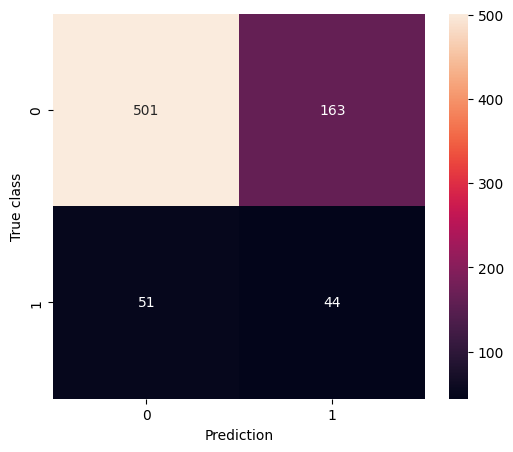

In [99]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [100]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.90      0.55      0.68       664\n        True       0.15      0.56      0.24        95\n\n    accuracy                           0.55       759\n   macro avg       0.52      0.55      0.46       759\nweighted avg       0.80      0.55      0.62       759\n'

Text(45.722222222222214, 0.5, 'True class')

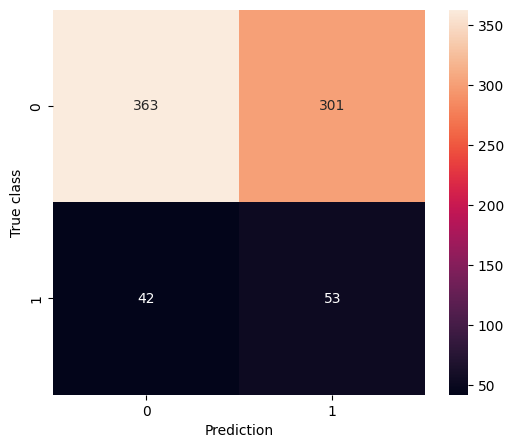

In [101]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [102]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = GaussianNB()
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.89      0.70      0.79       664\n        True       0.17      0.42      0.24        95\n\n    accuracy                           0.67       759\n   macro avg       0.53      0.56      0.51       759\nweighted avg       0.80      0.67      0.72       759\n'

Text(45.722222222222214, 0.5, 'True class')

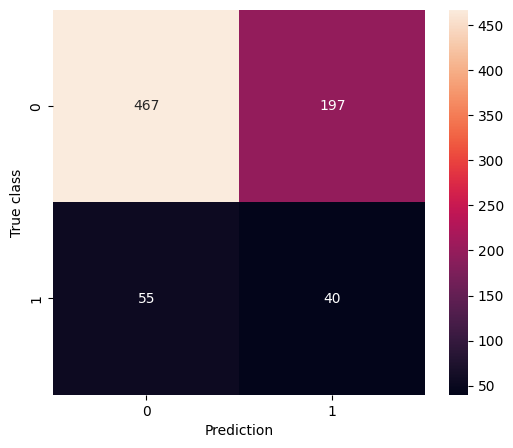

In [103]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

# RF models

In [104]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False, sublinear_tf = True, min_df = round(len(message_train)/1000), max_df = 0.6)

train_tf = tfidf.fit_transform(message_train['lemmas'])
validate_tf = tfidf.transform(message_val['lemmas'])

vocab = tfidf.get_feature_names_out()

# Train Naive Bayes classifier


classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(train_tf, message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(validate_tf))

C:\Users\woute\OneDrive\Documenten\JADS\Thesis\venv_Thesis\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'              precision    recall  f1-score   support\n\n       False       0.88      0.98      0.93       664\n        True       0.35      0.06      0.11        95\n\n    accuracy                           0.87       759\n   macro avg       0.62      0.52      0.52       759\nweighted avg       0.81      0.87      0.83       759\n'

Text(45.722222222222214, 0.5, 'True class')

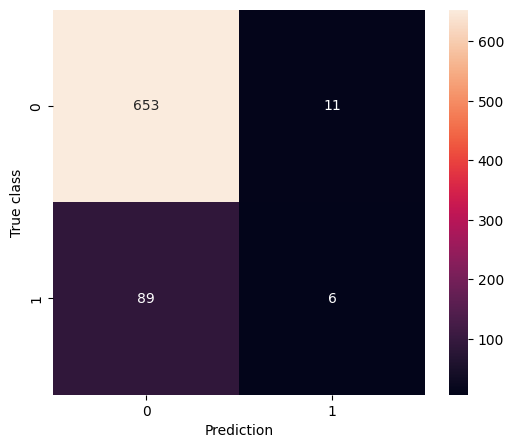

In [105]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(validate_tf))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [106]:
def create_embedding(product_name, word_embeddings, vector_size = 300):
    embeddings = list()
    for token in product_name:
        if token in word_embeddings:
            embeddings.append(word_embeddings[token])
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

model = Word2Vec(sentences = message_data.lemmas.to_list(), vector_size = 300, min_count = 50, sg = 1)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model.wv))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model.wv))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      0.98      0.93       664\n        True       0.29      0.05      0.09        95\n\n    accuracy                           0.87       759\n   macro avg       0.59      0.52      0.51       759\nweighted avg       0.81      0.87      0.82       759\n'

Text(45.722222222222214, 0.5, 'True class')

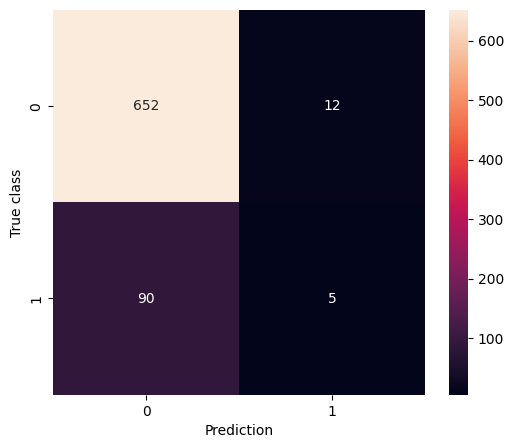

In [107]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')

In [108]:
model = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

message_train['doc_embeddings'] = message_train.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

message_val['doc_embeddings'] = message_val.lemmas.apply(lambda x: create_embedding(x, model, vector_size=200))

classifier = RandomForestClassifier(n_estimators = 500, random_state = 404)
classifier.fit(np.array(message_train['doc_embeddings'].tolist()), message_train['ragequit_t+12'])

classification_report(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))

'              precision    recall  f1-score   support\n\n       False       0.88      1.00      0.93       664\n        True       0.50      0.01      0.02        95\n\n    accuracy                           0.87       759\n   macro avg       0.69      0.50      0.48       759\nweighted avg       0.83      0.87      0.82       759\n'

Text(45.722222222222214, 0.5, 'True class')

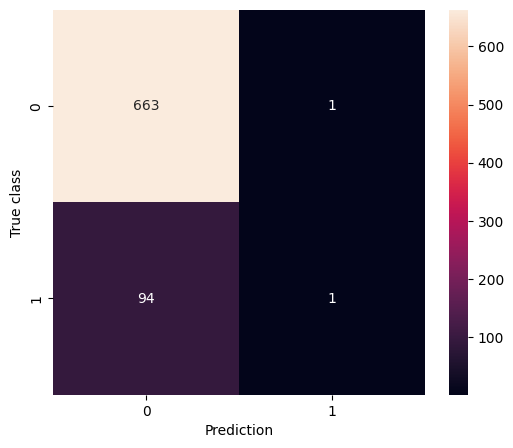

In [109]:
cm = confusion_matrix(message_val['ragequit_t+12'], classifier.predict(np.array(message_val['doc_embeddings'].tolist()),))
fig = plt.figure(figsize=(6,5))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g');
ax.set_xlabel('Prediction')
ax.set_ylabel('True class')